In [1]:
""" Created on November 9, 2023 // @author: Sarah Shi """

import numpy as np
import pandas as pd
import scipy
import random
import torch
import torch.nn as nn
from torch.nn.modules.activation import LeakyReLU, Sigmoid
from torch.utils.data import Dataset, DataLoader

import os 
import time 
import json 
import pickle
import pygmt
import warnings

from scipy.sparse import (SparseEfficiencyWarning)
warnings.simplefilter('ignore', category=(FutureWarning,SparseEfficiencyWarning))
from scipy.special import softmax

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import Isomap, LocallyLinearEmbedding, TSNE
from sklearn.preprocessing import scale, normalize, StandardScaler

import TAS as tas
import Thermobar as pt
import stoichiometry as mm

import matplotlib
from matplotlib import pyplot as plt
from matplotlib import rc
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.patches as mpatches
import matplotlib.cm as mcm
import matplotlib.path as mpath
import matplotlib.colors as mcolors

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
rc('font',**{'family':'Avenir', 'size': 14})
plt.rcParams['pdf.fonttype'] = 42

pt.__version__

'1.0.10'

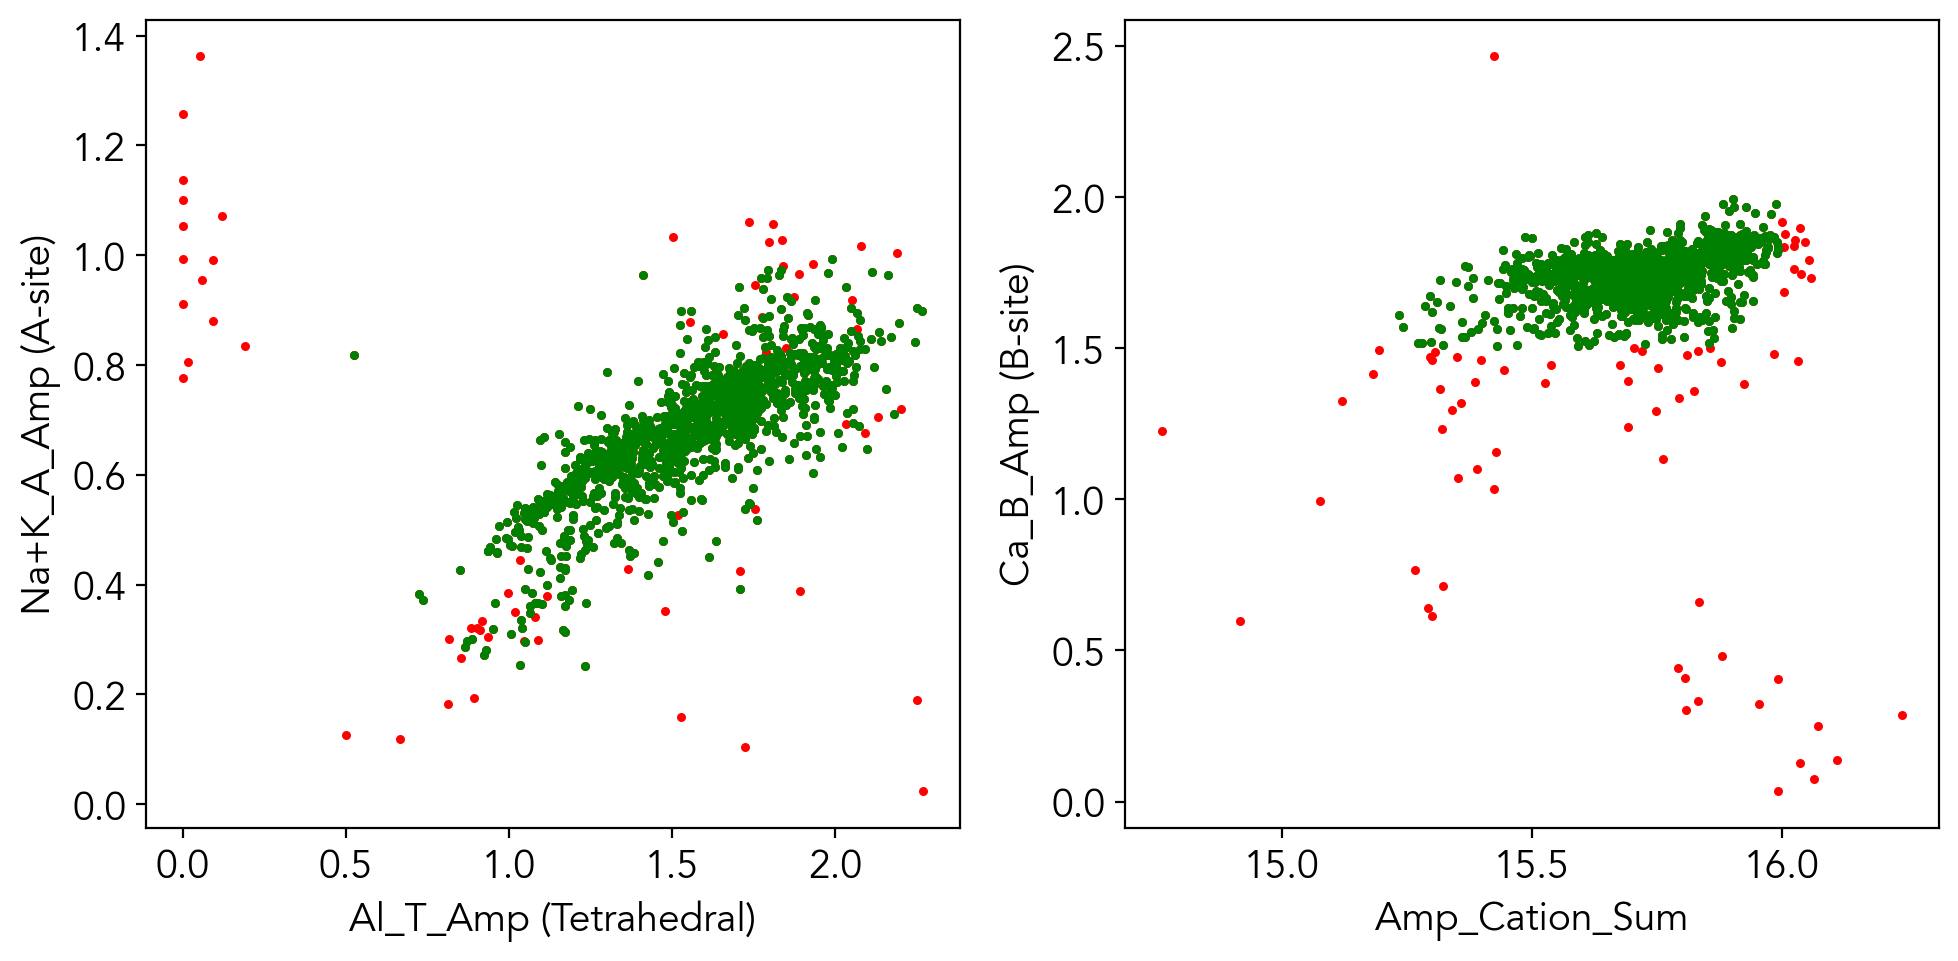

In [2]:
LEPR_Amp_PreFilt = pt.import_excel('MachineLearning_MinClass.xlsx', sheet_name="Amp")['Amps']
LEPR_Amp_cs = mm.get_amp_sites_from_input_not_amp(LEPR_Amp_PreFilt, "_Amp")
LEPR_Amp_cs['Na_K_A_Amp'] = LEPR_Amp_cs['Na_A_Amp'] + LEPR_Amp_cs['K_A_Amp']

LEPR_Amp_Pre = pd.concat([LEPR_Amp_PreFilt, LEPR_Amp_cs], axis = 1)
LEPR_Amp = LEPR_Amp_PreFilt.loc[((LEPR_Amp_cs['Amp_Cation_Sum'].between(15, 16)) & (LEPR_Amp_cs['Ca_B_Amp'].between(1.5, 2.1)))]
LEPR_Amp_nosuf = mm.SiteCalculator(LEPR_Amp, '_Amp', 'Amphibole')

fig, ax = plt.subplots(1, 2, figsize = (10, 5))
ax = ax.flatten()
# Blundy and Holland, 1990 plot A_site v. Al_IV and Al_VI v. Al_IV
ax[0].scatter(LEPR_Amp_Pre['Al_T_Amp'], LEPR_Amp_Pre['Na_K_A_Amp'], s = 5, color = 'r')
ax[0].scatter(LEPR_Amp_nosuf['Al_T_Amp'], LEPR_Amp_nosuf['Na_K_A_Amp'], s = 5, color = 'g')
ax[0].set_xlabel('Al_T_Amp (Tetrahedral)')
ax[0].set_ylabel('Na+K_A_Amp (A-site)')
ax[1].scatter(LEPR_Amp_Pre['Amp_Cation_Sum'], LEPR_Amp_Pre['Ca_B_Amp'], s = 5, color = 'r')
ax[1].scatter(LEPR_Amp_nosuf['Amp_Cation_Sum'], LEPR_Amp_nosuf['Ca_B_Amp'], s = 5, color = 'g')
ax[1].set_xlabel('Amp_Cation_Sum')
ax[1].set_ylabel('Ca_B_Amp (B-site)')
plt.tight_layout()

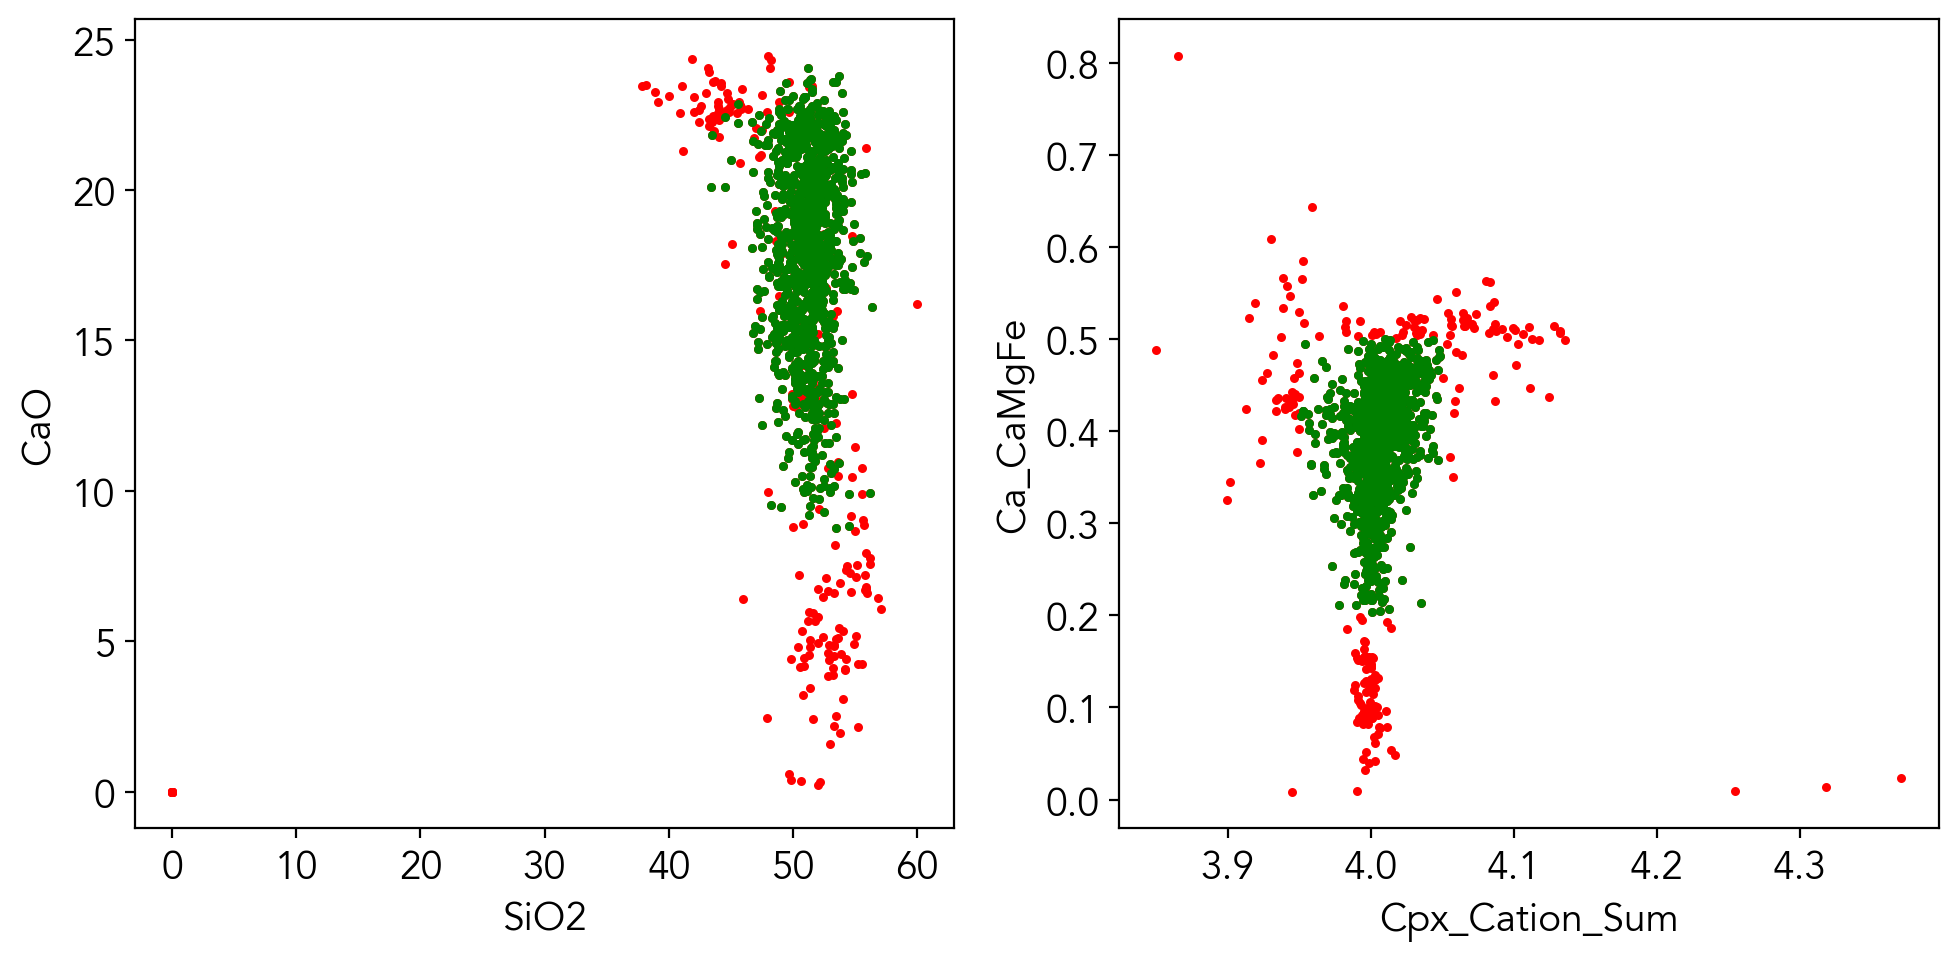

In [3]:
LEPR_Cpx_PreFilt = pt.import_excel('MachineLearning_MinClass.xlsx', sheet_name="Cpx")['Cpxs']
LEPR_Cpx_cs = mm.calculate_clinopyroxene_components(cpx_comps=LEPR_Cpx_PreFilt)
LEPR_Cpx_Pre = LEPR_Cpx_cs.copy()
LEPR_Cpx = LEPR_Cpx_PreFilt.loc[((LEPR_Cpx_cs.Cpx_Cation_Sum.between(3.95, 4.05)) & (LEPR_Cpx_cs.Ca_CaMgFe_Cpx.between(0.2, 0.5)) )]
LEPR_Cpx_nosuf = mm.SiteCalculator(LEPR_Cpx, '_Cpx', 'Clinopyroxene')

fig, ax = plt.subplots(1, 2, figsize = (10, 5))
ax = ax.flatten()
ax[0].scatter(LEPR_Cpx_cs['SiO2_Cpx'], LEPR_Cpx_cs['CaO_Cpx'], s = 5, color = 'r')
ax[0].scatter(LEPR_Cpx_nosuf['SiO2_Cpx'], LEPR_Cpx_nosuf['CaO_Cpx'], s = 5, color = 'g')
ax[0].set_xlabel('SiO2')
ax[0].set_ylabel('CaO')
ax[1].scatter(LEPR_Cpx_cs['Cpx_Cation_Sum'], LEPR_Cpx_cs['Ca_CaMgFe_Cpx'], s = 5, color = 'r')
ax[1].scatter(LEPR_Cpx_nosuf['Cpx_Cation_Sum'], LEPR_Cpx_nosuf['Ca_CaMgFe_Cpx'], s = 5, color = 'g')
ax[1].set_xlabel('Cpx_Cation_Sum')
ax[1].set_ylabel('Ca_CaMgFe')
plt.tight_layout()

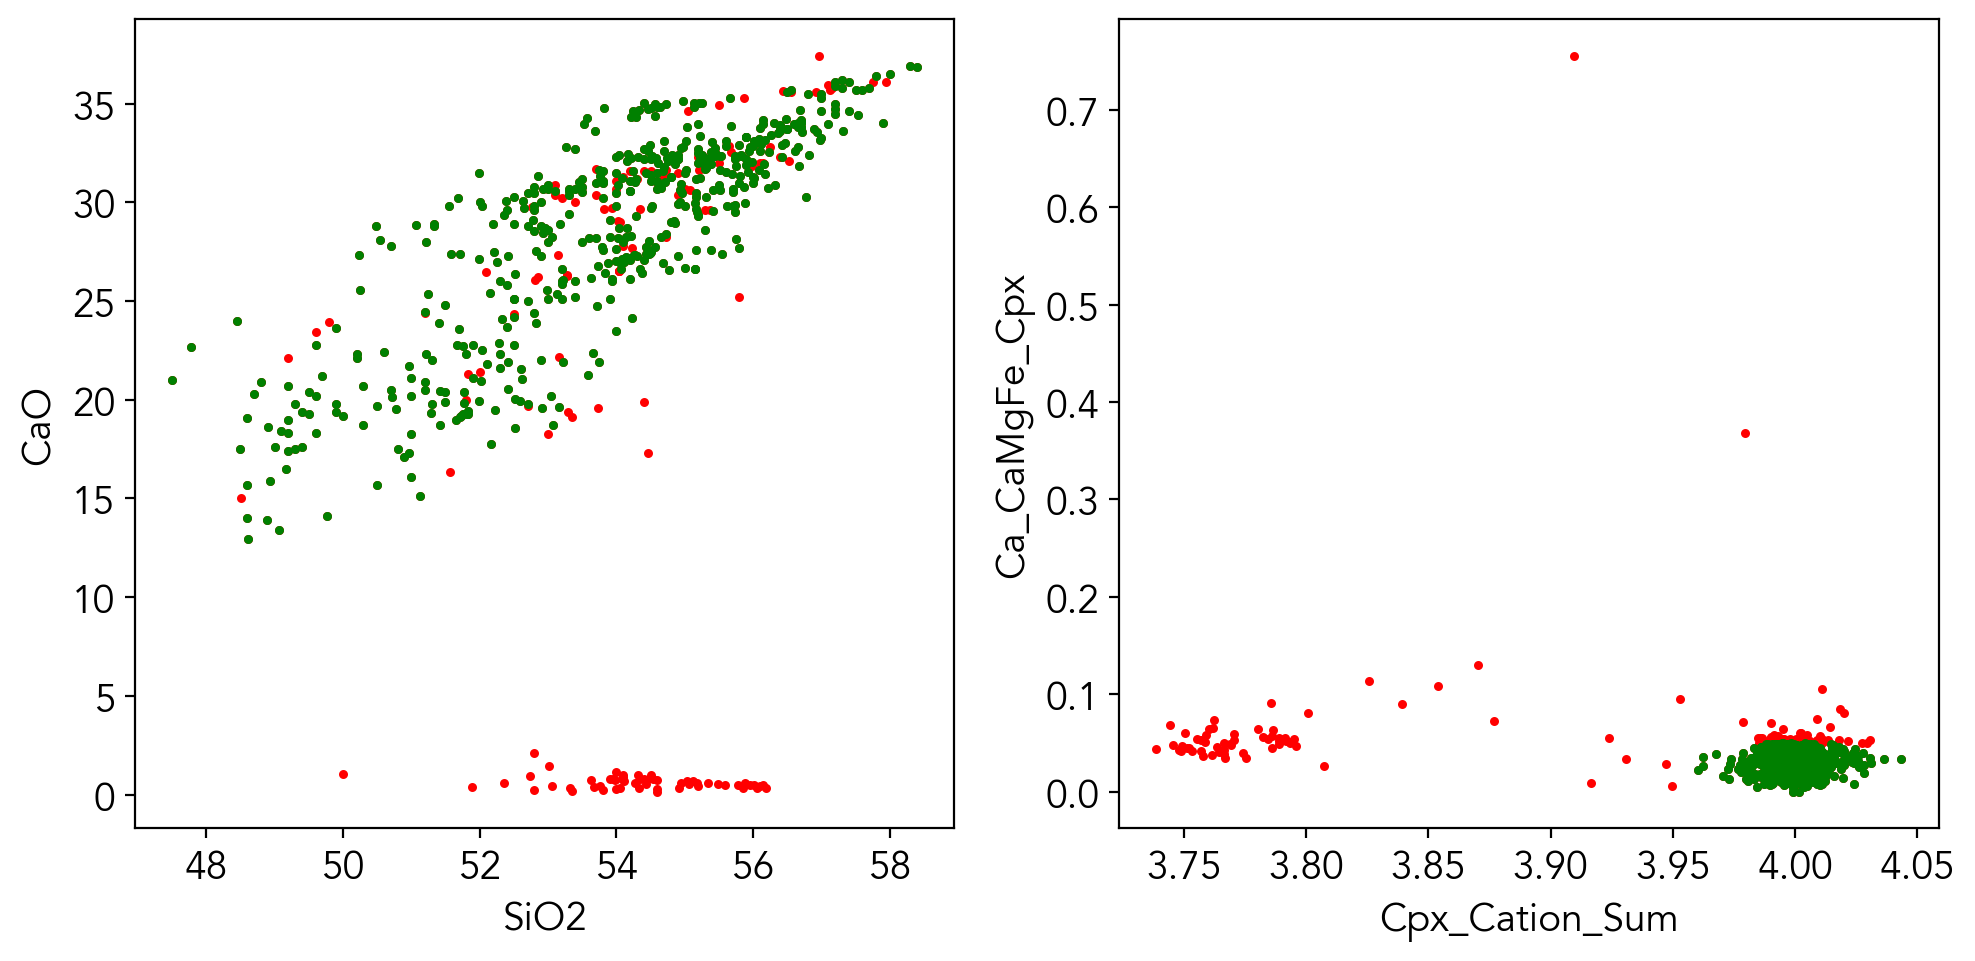

In [4]:
LEPR_Opx_PreFilt = pt.import_excel('MachineLearning_MinClass.xlsx', sheet_name="Opx")['Opxs']
LEPR_Opx_cs = mm.calculate_orthopyroxene_components(opx_comps=LEPR_Opx_PreFilt)
# LEPR_Opx_cs = LEPR_Opx_cs.rename(columns = {'Cation_Sum_Opx': 'Opx_Cation_Sum', 'Ca_CaMgFe': 'Ca_CaMgFe_Opx'})
LEPR_Opx_Pre = LEPR_Opx_cs
LEPR_Opx = LEPR_Opx_PreFilt.loc[( (LEPR_Opx_cs.Opx_Cation_Sum.between(3.95, 4.05)) & (LEPR_Opx_cs.Ca_CaMgFe_Opx.between(-0.01, 0.05) )) ]
LEPR_Opx_nosuf = mm.SiteCalculator(LEPR_Opx, '_Opx', 'Orthopyroxene')

fig, ax = plt.subplots(1, 2, figsize = (10, 5))
ax = ax.flatten()
ax[0].scatter(LEPR_Opx_cs['SiO2_Opx'], LEPR_Opx_cs['MgO_Opx'], s = 5, color = 'r')
ax[0].scatter(LEPR_Opx_nosuf['SiO2_Opx'], LEPR_Opx_nosuf['MgO_Opx'], s = 5, color = 'g')
ax[0].set_xlabel('SiO2')
ax[0].set_ylabel('CaO')
ax[1].scatter(LEPR_Opx_cs['Opx_Cation_Sum'], LEPR_Opx_cs['Ca_CaMgFe_Opx'], s = 5, color = 'r')
ax[1].scatter(LEPR_Opx_nosuf['Opx_Cation_Sum'], LEPR_Opx_nosuf['Ca_CaMgFe_Opx'], s = 5, color = 'g')
ax[1].set_xlabel('Cpx_Cation_Sum')
ax[1].set_ylabel('Ca_CaMgFe_Cpx')
plt.tight_layout()

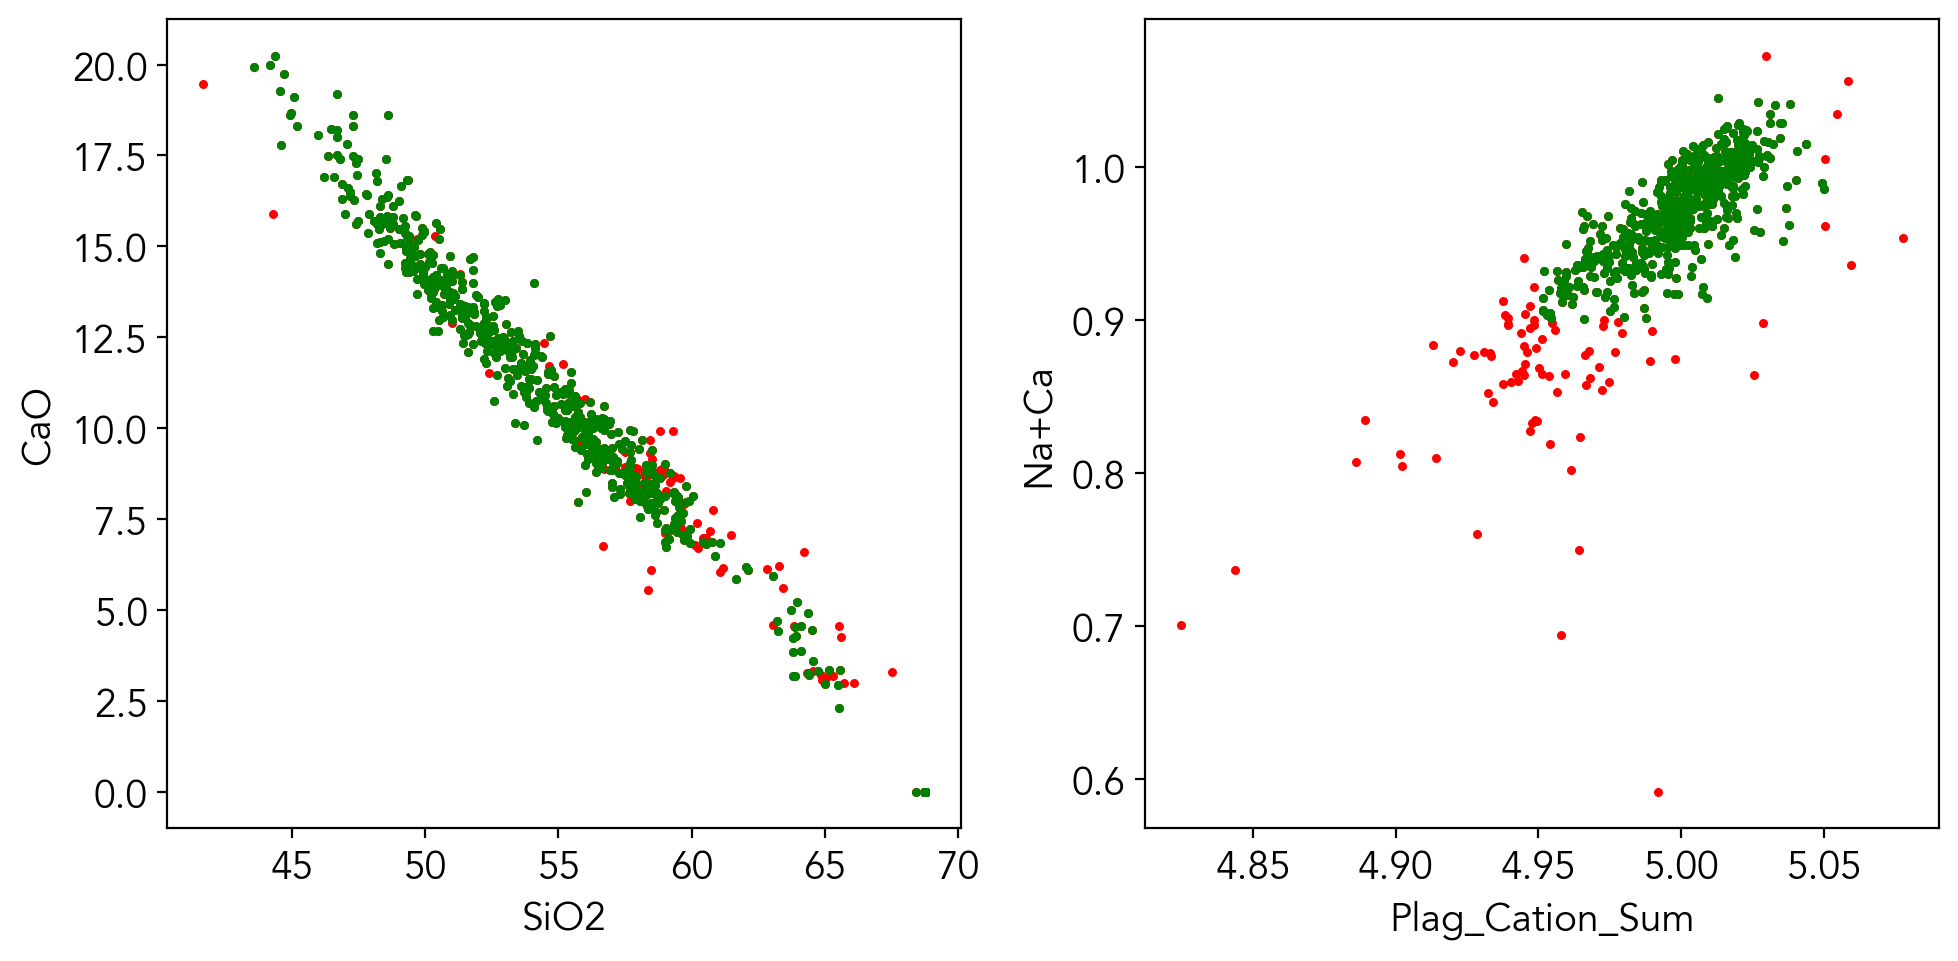

In [5]:
LEPR_Plag_PreFilt = pt.import_excel('MachineLearning_MinClass.xlsx', sheet_name="Plag")['Plags']
LEPR_Plag_cs = mm.calculate_plagioclase_components(plag_comps=LEPR_Plag_PreFilt, append = '_Plag')
LEPR_Plag_Pre = LEPR_Plag_cs
LEPR_Plag = LEPR_Plag_PreFilt.loc[( (LEPR_Plag_cs.Plag_Cation_Sum.between(4.95, 5.05)) & (LEPR_Plag_cs.Na_Ca_M_Plag.between(0.9, 1.05) )) ]
LEPR_Plag_nosuf = mm.SiteCalculator(LEPR_Plag, '_Plag', 'Plagioclase')

fig, ax = plt.subplots(1, 2, figsize = (10, 5))
ax = ax.flatten()
ax[0].scatter(LEPR_Plag_cs['SiO2_Plag'], LEPR_Plag_cs['CaO_Plag'], s = 5, color = 'r')
ax[0].scatter(LEPR_Plag_nosuf['SiO2_Plag'], LEPR_Plag_nosuf['CaO_Plag'], s = 5, color = 'g')
ax[0].set_xlabel('SiO2')
ax[0].set_ylabel('CaO')
ax[1].scatter(LEPR_Plag_cs['Plag_Cation_Sum'], LEPR_Plag_cs['Na_Ca_M_Plag'], s = 5, color = 'r')
ax[1].scatter(LEPR_Plag_nosuf['Plag_Cation_Sum'], LEPR_Plag_nosuf['Na_Ca_M_Plag'], s = 5, color = 'g')
ax[1].set_xlabel('Plag_Cation_Sum')
ax[1].set_ylabel('Na+Ca')
plt.tight_layout()

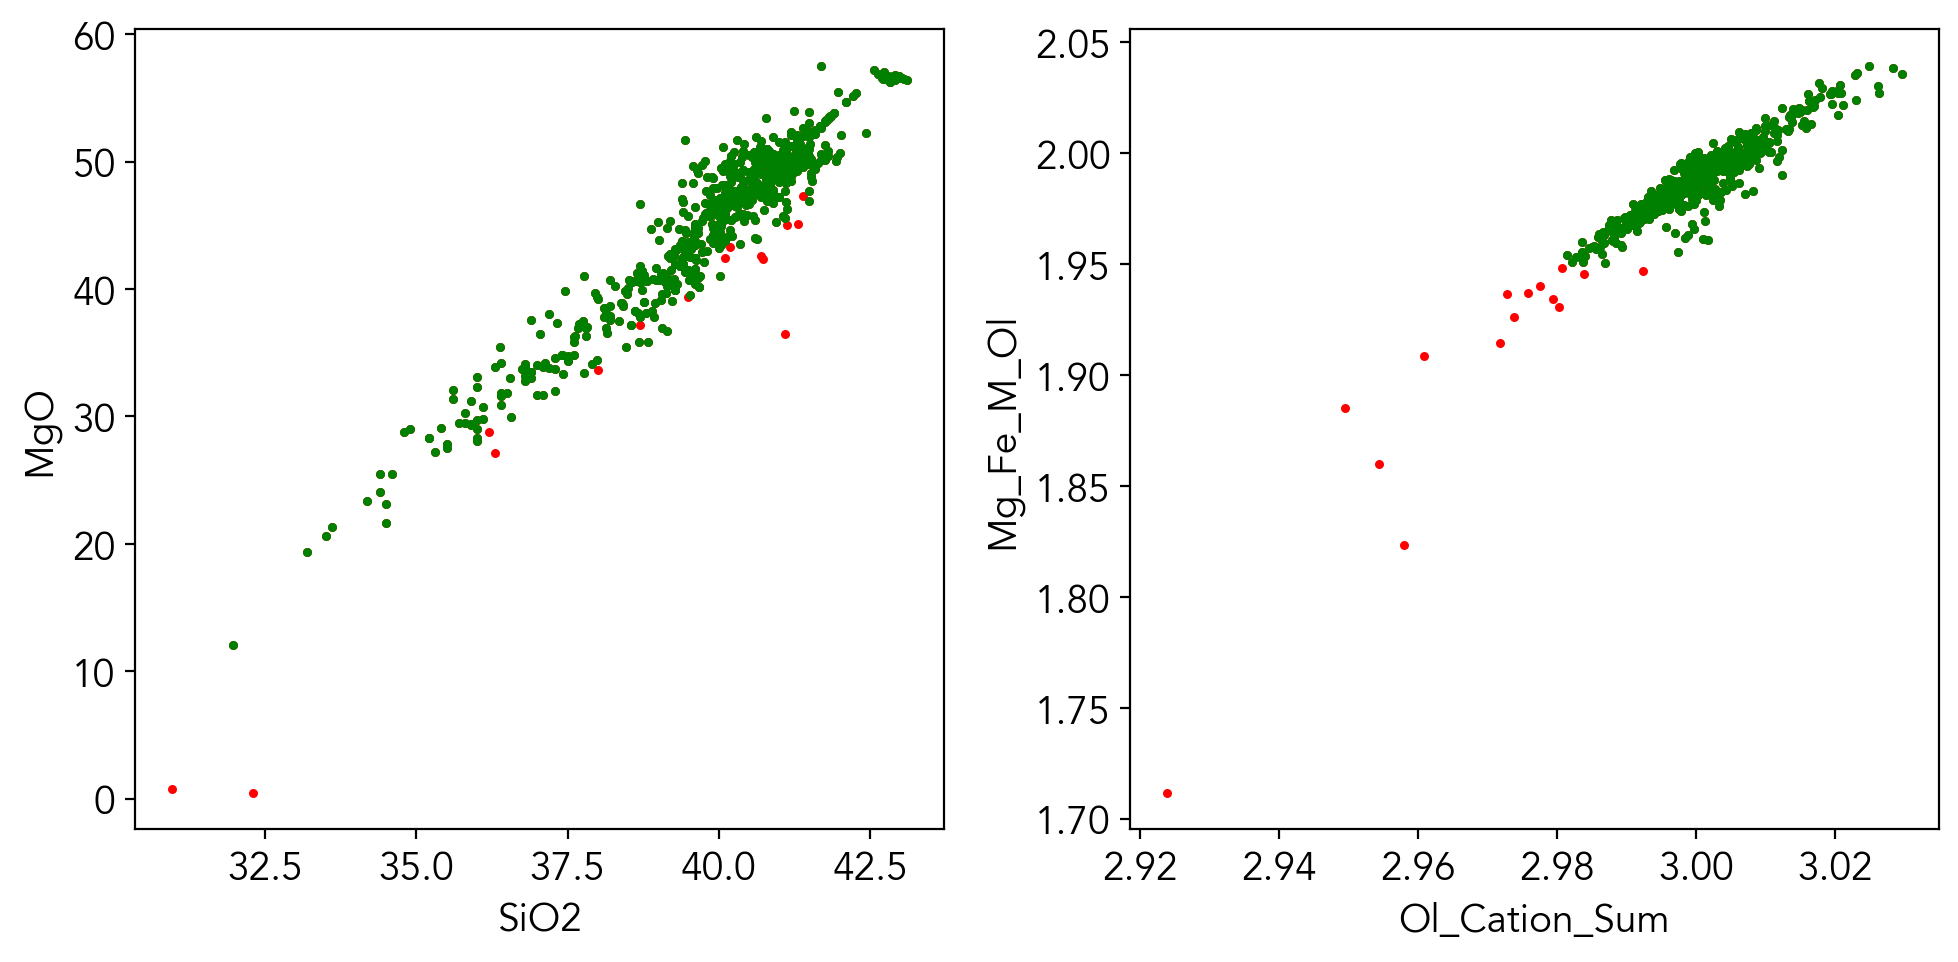

In [6]:
LEPR_Ol_PreFilt = pt.import_excel('MachineLearning_MinClass.xlsx', sheet_name="Ol")['Ols']
LEPR_Ol_cs = mm.calculate_olivine_components(ol_comps=LEPR_Ol_PreFilt, append = '_Ol')
LEPR_Ol_Pre = LEPR_Ol_cs
LEPR_Ol = LEPR_Ol_PreFilt.loc[( (LEPR_Ol_cs.Ol_Cation_Sum.between(2.95, 3.05)) & (LEPR_Ol_cs.Mg_Fe_M_Ol.between(1.95, 2.05) )) ]
LEPR_Ol_nosuf = mm.SiteCalculator(LEPR_Ol, '_Ol', 'Olivine')

fig, ax = plt.subplots(1, 2, figsize = (10, 5))
ax = ax.flatten()
ax[0].scatter(LEPR_Ol_cs['SiO2_Ol'], LEPR_Ol_cs['MgO_Ol'], s = 5, color = 'r')
ax[0].scatter(LEPR_Ol_nosuf['SiO2_Ol'], LEPR_Ol_nosuf['MgO_Ol'], s = 5, color = 'g')
ax[0].set_xlabel('SiO2')
ax[0].set_ylabel('MgO')
ax[1].scatter(LEPR_Ol_cs['Ol_Cation_Sum'], LEPR_Ol_cs['Mg_Fe_M_Ol'], s = 5, color = 'r')
ax[1].scatter(LEPR_Ol_nosuf['Ol_Cation_Sum'], LEPR_Ol_nosuf['Mg_Fe_M_Ol'], s = 5, color = 'g')
ax[1].set_xlabel('Ol_Cation_Sum')
ax[1].set_ylabel('Mg_Fe_M_Ol')
plt.tight_layout()

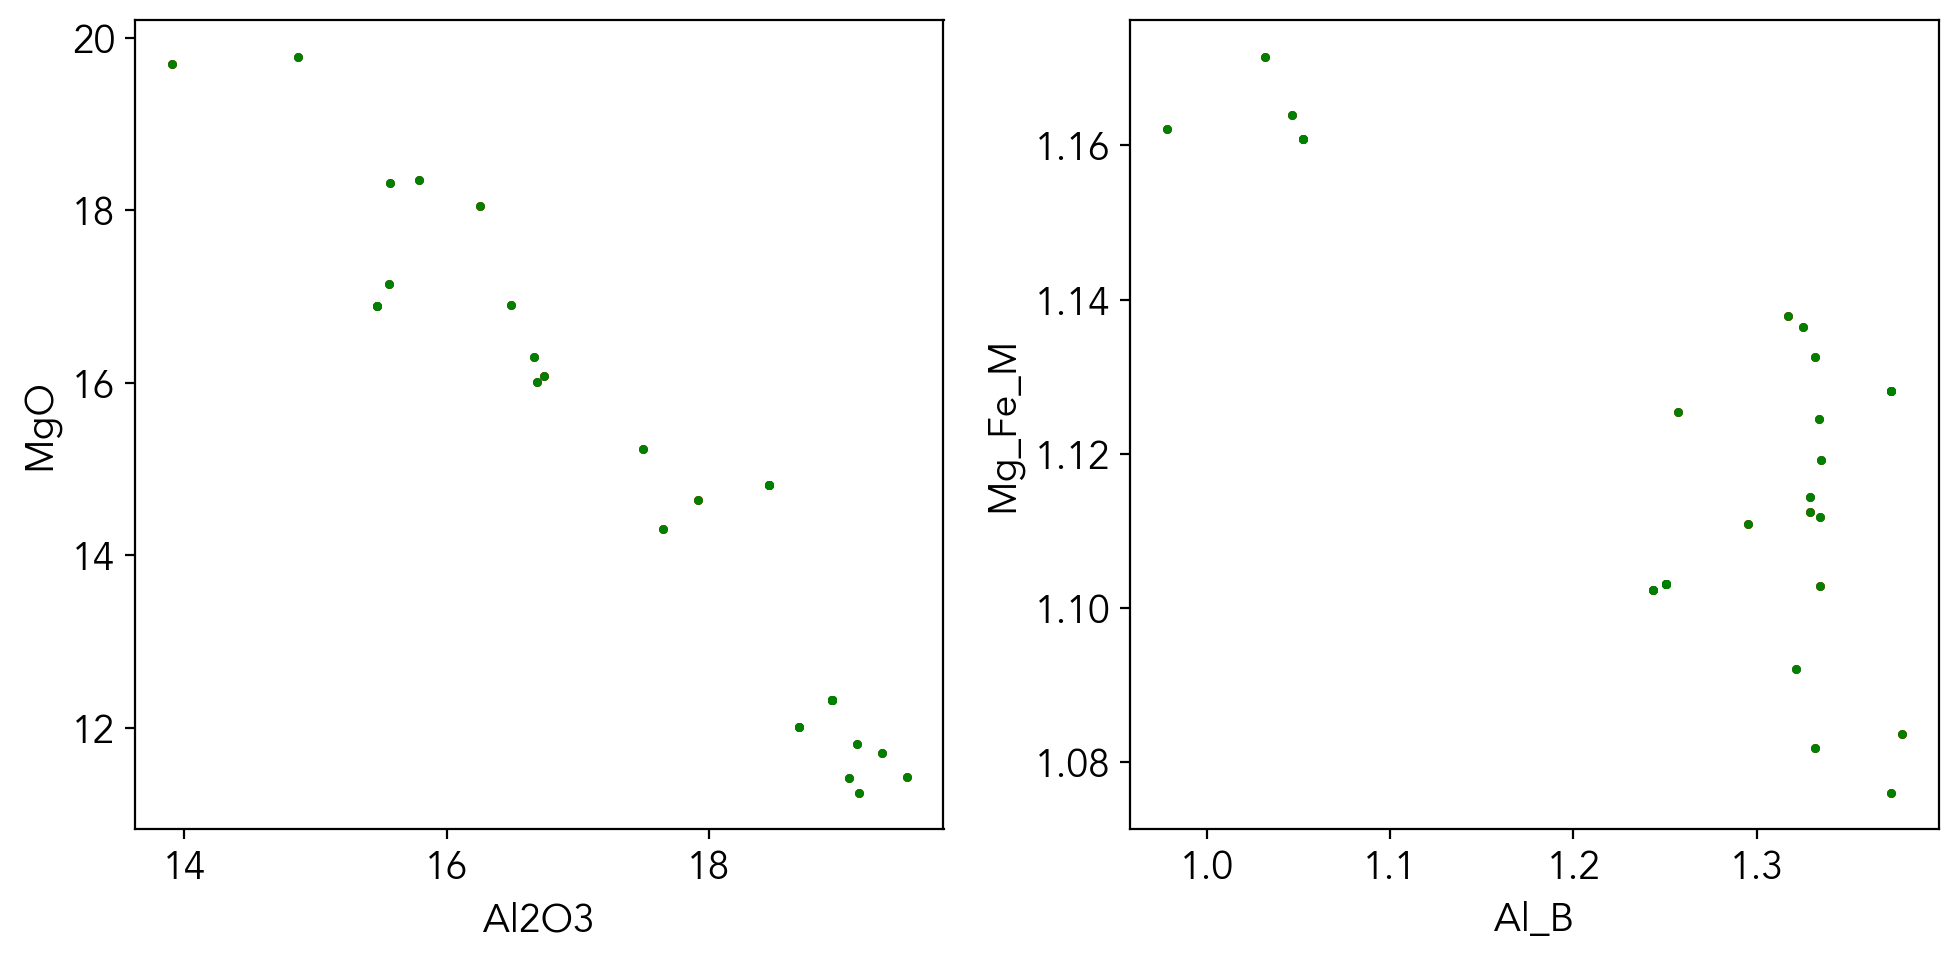

In [7]:
LEPR_Sp_PreFilt = pt.import_excel('MachineLearning_MinClass.xlsx', sheet_name="Cr_Sp")['Sps']
LEPR_Sp_cs = mm.calculate_spinel_components(sp_comps=LEPR_Sp_PreFilt, append = '_Sp')
LEPR_Sp_Pre = LEPR_Sp_cs
LEPR_Sp = LEPR_Sp_PreFilt.copy()
LEPR_Sp_nosuf = mm.SiteCalculator(LEPR_Sp, '_Sp', 'Spinel')

fig, ax = plt.subplots(1, 2, figsize = (10, 5))
ax = ax.flatten()
ax[0].scatter(LEPR_Sp_Pre['MgO_Sp'], LEPR_Sp_Pre['FeOt_Sp'], s = 5, color = 'r')
ax[0].scatter(LEPR_Sp_nosuf['MgO_Sp'], LEPR_Sp_nosuf['FeOt_Sp'], s = 5, color = 'g')
ax[0].set_xlabel('Al2O3')
ax[0].set_ylabel('MgO')

ax[1].scatter(LEPR_Sp_Pre['Al_B_Sp'], LEPR_Sp_cs['Mg_Fe_M_Sp'], s = 5, color = 'r')
ax[1].scatter(LEPR_Sp_nosuf['Al_B_Sp'], LEPR_Sp_nosuf['Mg_Fe_M_Sp'], s = 5, color = 'g')
ax[1].set_xlabel('Al_B')
ax[1].set_ylabel('Mg_Fe_M')
plt.tight_layout()

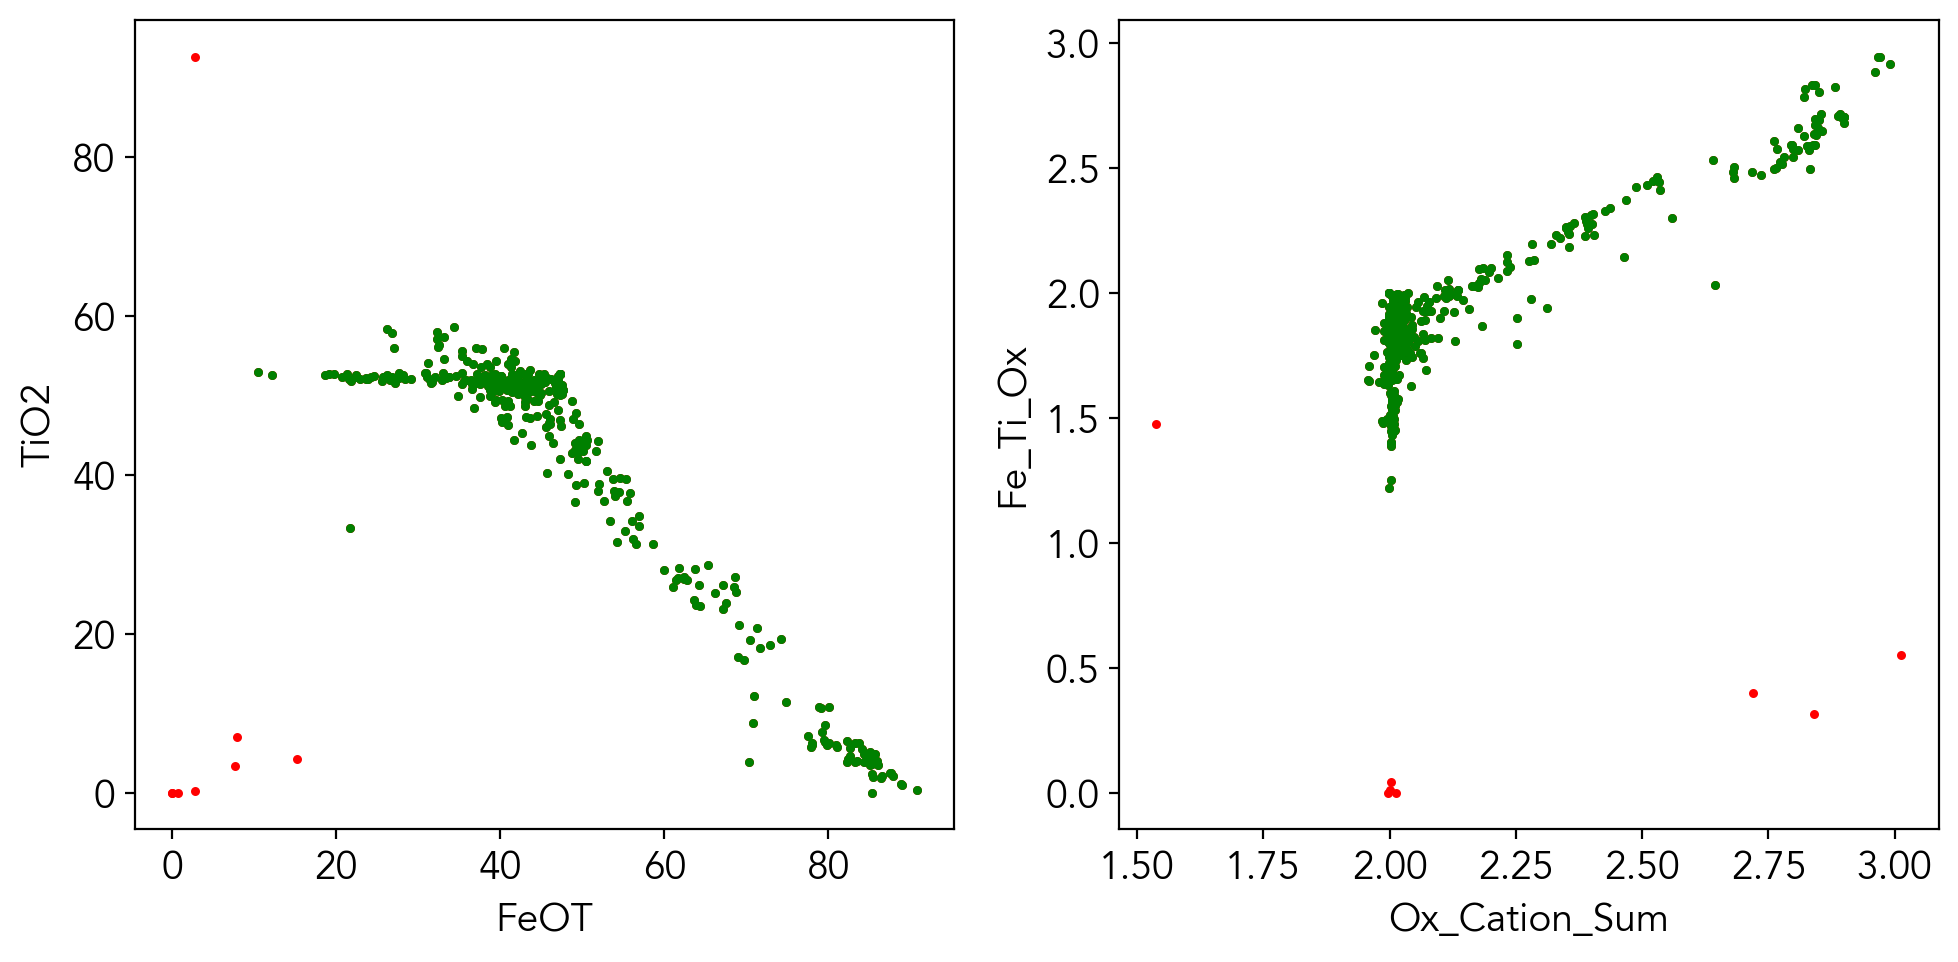

In [8]:
LEPR_Ox_PreFilt = pt.import_excel('MachineLearning_MinClass.xlsx', sheet_name="Oxide")['Sps']
LEPR_Ox_cs = mm.calculate_oxide_components(ox_comps=LEPR_Ox_PreFilt, append = '_Sp')
LEPR_Ox_Pre = LEPR_Ox_cs
LEPR_Ox = LEPR_Ox_PreFilt.loc[((LEPR_Ox_cs.Ox_Cation_Sum.between(1.95, 3.05)) & (LEPR_Ox_cs.Fe_Ti_Ox.between(1.0, 3.0)) )]

LEPR_Ox_nosuf = mm.SiteCalculator(LEPR_Ox, '_Sp', 'Oxide')

fig, ax = plt.subplots(1, 2, figsize = (10, 5))
ax = ax.flatten()
ax[0].scatter(LEPR_Ox_Pre['FeOt_Sp'], LEPR_Ox_Pre['TiO2_Sp'], s = 5, color = 'r')
ax[0].scatter(LEPR_Ox_nosuf['FeOt_Sp'], LEPR_Ox_nosuf['TiO2_Sp'], s = 5, color = 'g')
ax[0].set_xlabel('FeOT')
ax[0].set_ylabel('TiO2')

ax[1].scatter(LEPR_Ox_Pre['Ox_Cation_Sum'], LEPR_Ox_cs['Fe_Ti_Ox'], s = 5, color = 'r')
ax[1].scatter(LEPR_Ox_nosuf['Ox_Cation_Sum'], LEPR_Ox_nosuf['Fe_Ti_Ox'], s = 5, color = 'g')
ax[1].set_xlabel('Ox_Cation_Sum')
ax[1].set_ylabel('Fe_Ti_Ox')
plt.tight_layout()

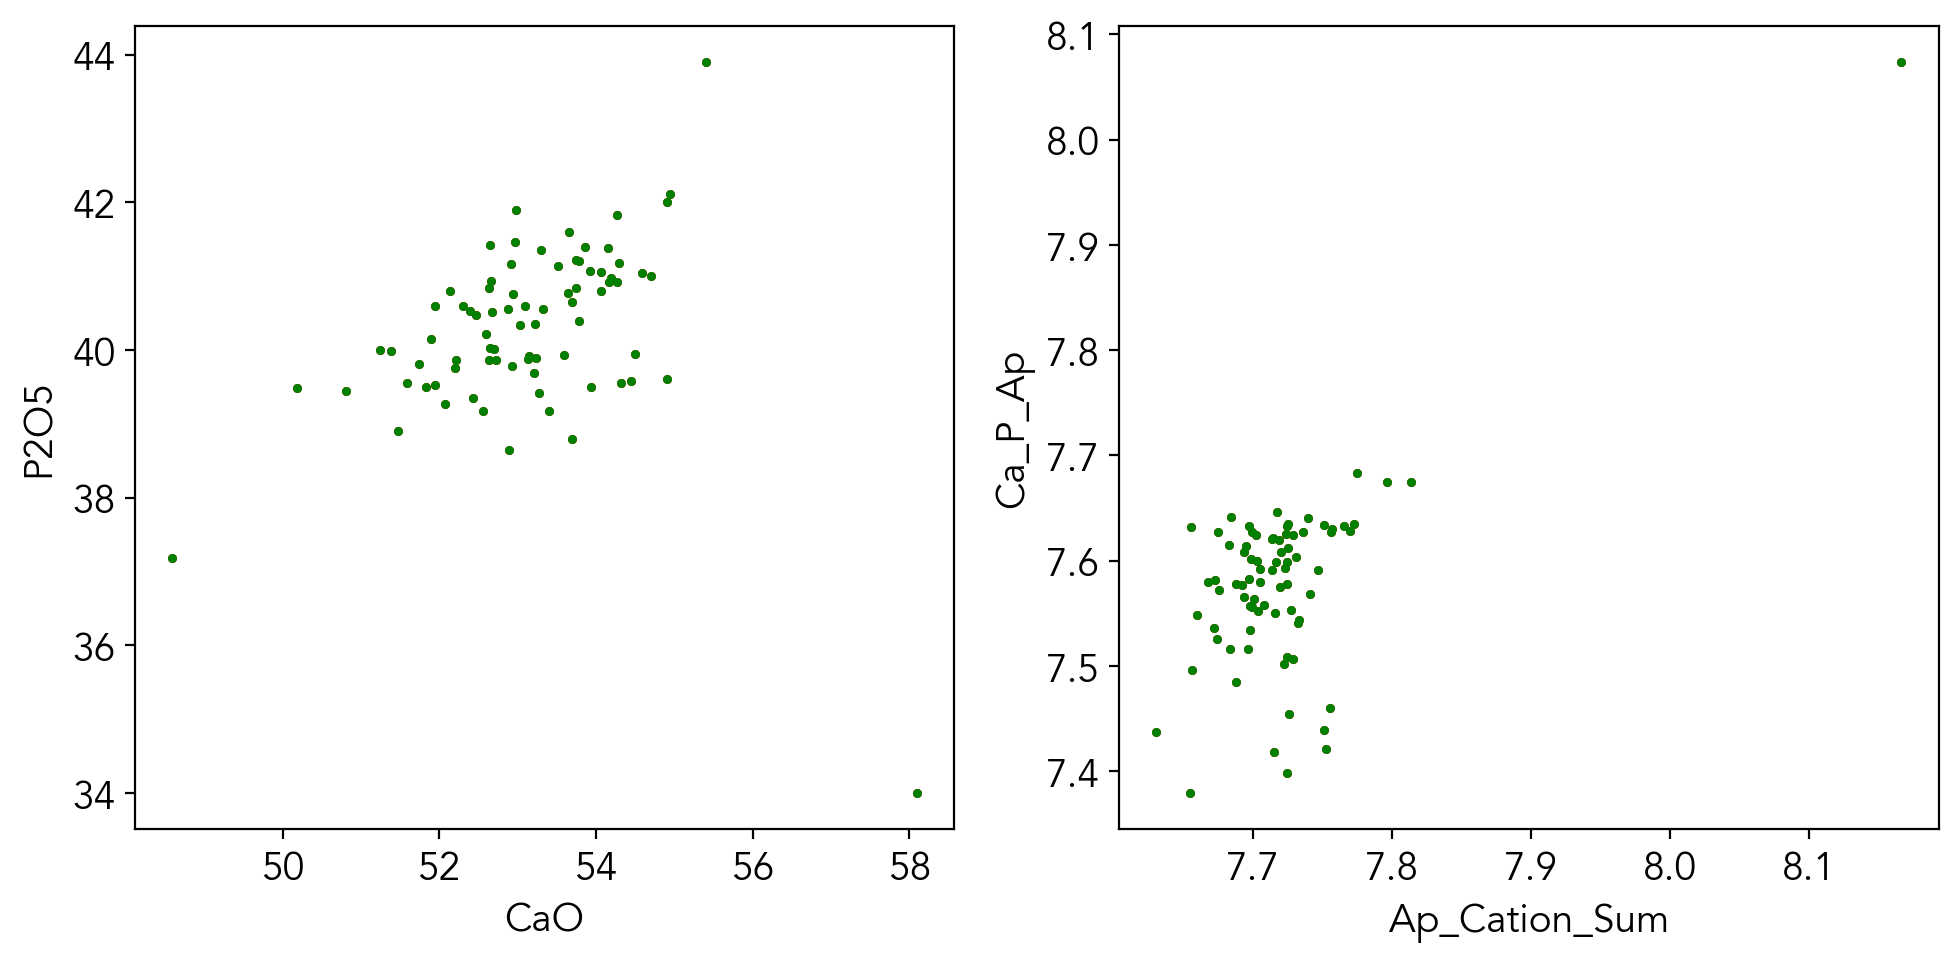

In [9]:
LEPR_Ap_PreFilt = pt.import_excel('MachineLearning_MinClass.xlsx', sheet_name="Apatite")['my_oxides']
LEPR_Ap_PreFilt = LEPR_Ap_PreFilt.add_suffix("_Ap")
LEPR_Ap_cs = mm.calculate_apatite_components(ap_comps=LEPR_Ap_PreFilt, append = '_Ap')
LEPR_Ap_Pre = LEPR_Ap_cs
# LEPR_Ap = LEPR_Ap_PreFilt.loc[((LEPR_Ap_cs.Ap_Cation_Sum.between(1.95, 3.05)) & (LEPR_Ap_cs.Fe_Ti_Ap.between(1.0, 3.0)) )]

LEPR_Ap_nosuf = mm.SiteCalculator(LEPR_Ap_PreFilt, '_Ap', 'Apatite')

fig, ax = plt.subplots(1, 2, figsize = (10, 5))
ax = ax.flatten()
ax[0].scatter(LEPR_Ap_Pre['CaO_Ap'], LEPR_Ap_Pre['P2O5_Ap'], s = 5, color = 'r')
ax[0].scatter(LEPR_Ap_nosuf['CaO_Ap'], LEPR_Ap_nosuf['P2O5_Ap'], s = 5, color = 'g')
ax[0].set_xlabel('CaO')
ax[0].set_ylabel('P2O5')
ax[1].scatter(LEPR_Ap_Pre['Ap_Cation_Sum'], LEPR_Ap_cs['Ca_P_Ap'], s = 5, color = 'r')
ax[1].scatter(LEPR_Ap_nosuf['Ap_Cation_Sum'], LEPR_Ap_nosuf['Ca_P_Ap'], s = 5, color = 'g')
ax[1].set_xlabel('Ap_Cation_Sum')
ax[1].set_ylabel('Ca_P_Ap')
plt.tight_layout()

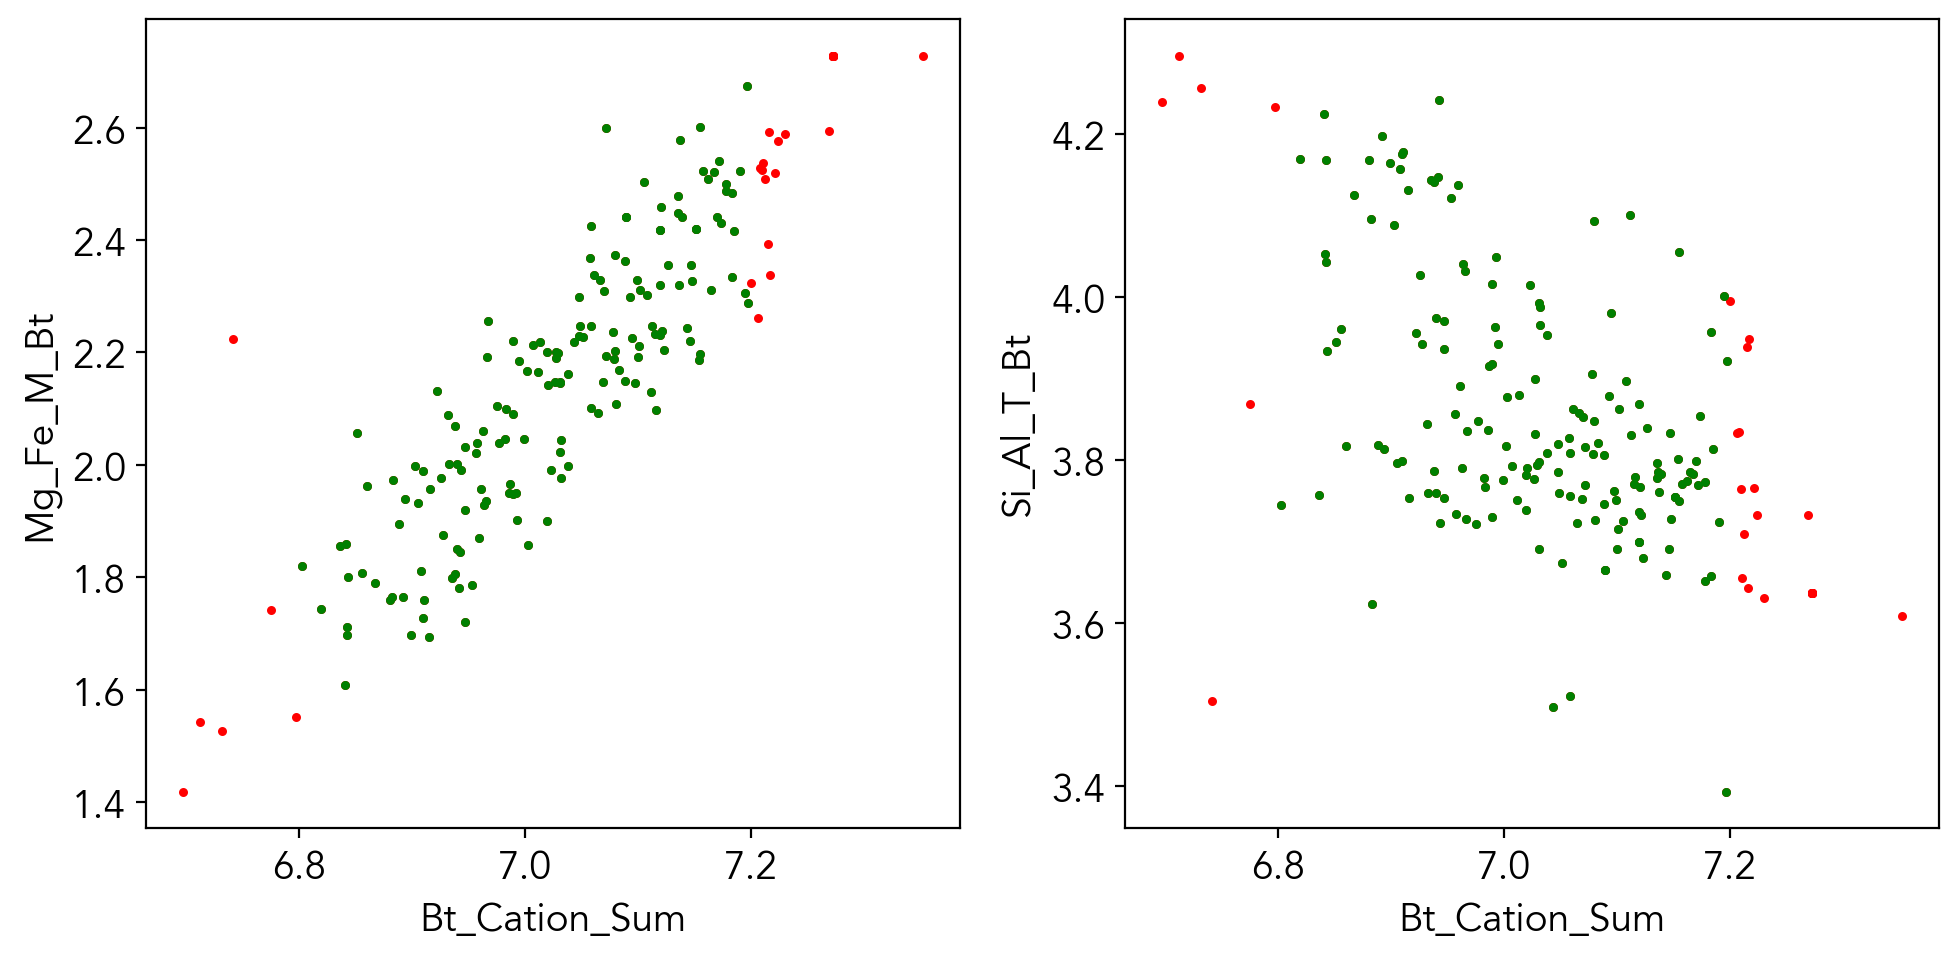

In [10]:
LEPR_Bt_PreFilt = pt.import_excel('MachineLearning_MinClass.xlsx', sheet_name="Biotite")['my_oxides']
LEPR_Bt_PreFilt = LEPR_Bt_PreFilt.add_suffix("_Bt")
LEPR_Bt_cs = mm.calculate_biotite_components(bt_comps=LEPR_Bt_PreFilt, append = '_Bt')
LEPR_Bt_Pre = LEPR_Bt_cs
LEPR_Bt = LEPR_Bt_PreFilt.loc[((LEPR_Bt_cs.Bt_Cation_Sum.between(6.8, 7.2)))]

LEPR_Bt_nosuf = mm.SiteCalculator(LEPR_Bt, '_Bt', 'Biotite')

fig, ax = plt.subplots(1, 2, figsize = (10, 5))
ax = ax.flatten()
ax[0].scatter(LEPR_Bt_Pre['Bt_Cation_Sum'], LEPR_Bt_Pre['Mg_Fe_M_Bt'], s = 5, color = 'r')
ax[0].scatter(LEPR_Bt_nosuf['Bt_Cation_Sum'], LEPR_Bt_nosuf['Mg_Fe_M_Bt'], s = 5, color = 'g')
ax[0].set_xlabel('Bt_Cation_Sum')
ax[0].set_ylabel('Mg_Fe_M_Bt')
ax[1].scatter(LEPR_Bt_Pre['Bt_Cation_Sum'], LEPR_Bt_Pre['Si_Al_T_Bt'], s = 5, color = 'r')
ax[1].scatter(LEPR_Bt_nosuf['Bt_Cation_Sum'], LEPR_Bt_nosuf['Si_Al_T_Bt'], s = 5, color = 'g')
ax[1].set_xlabel('Bt_Cation_Sum')
ax[1].set_ylabel('Si_Al_T_Bt')
plt.tight_layout()

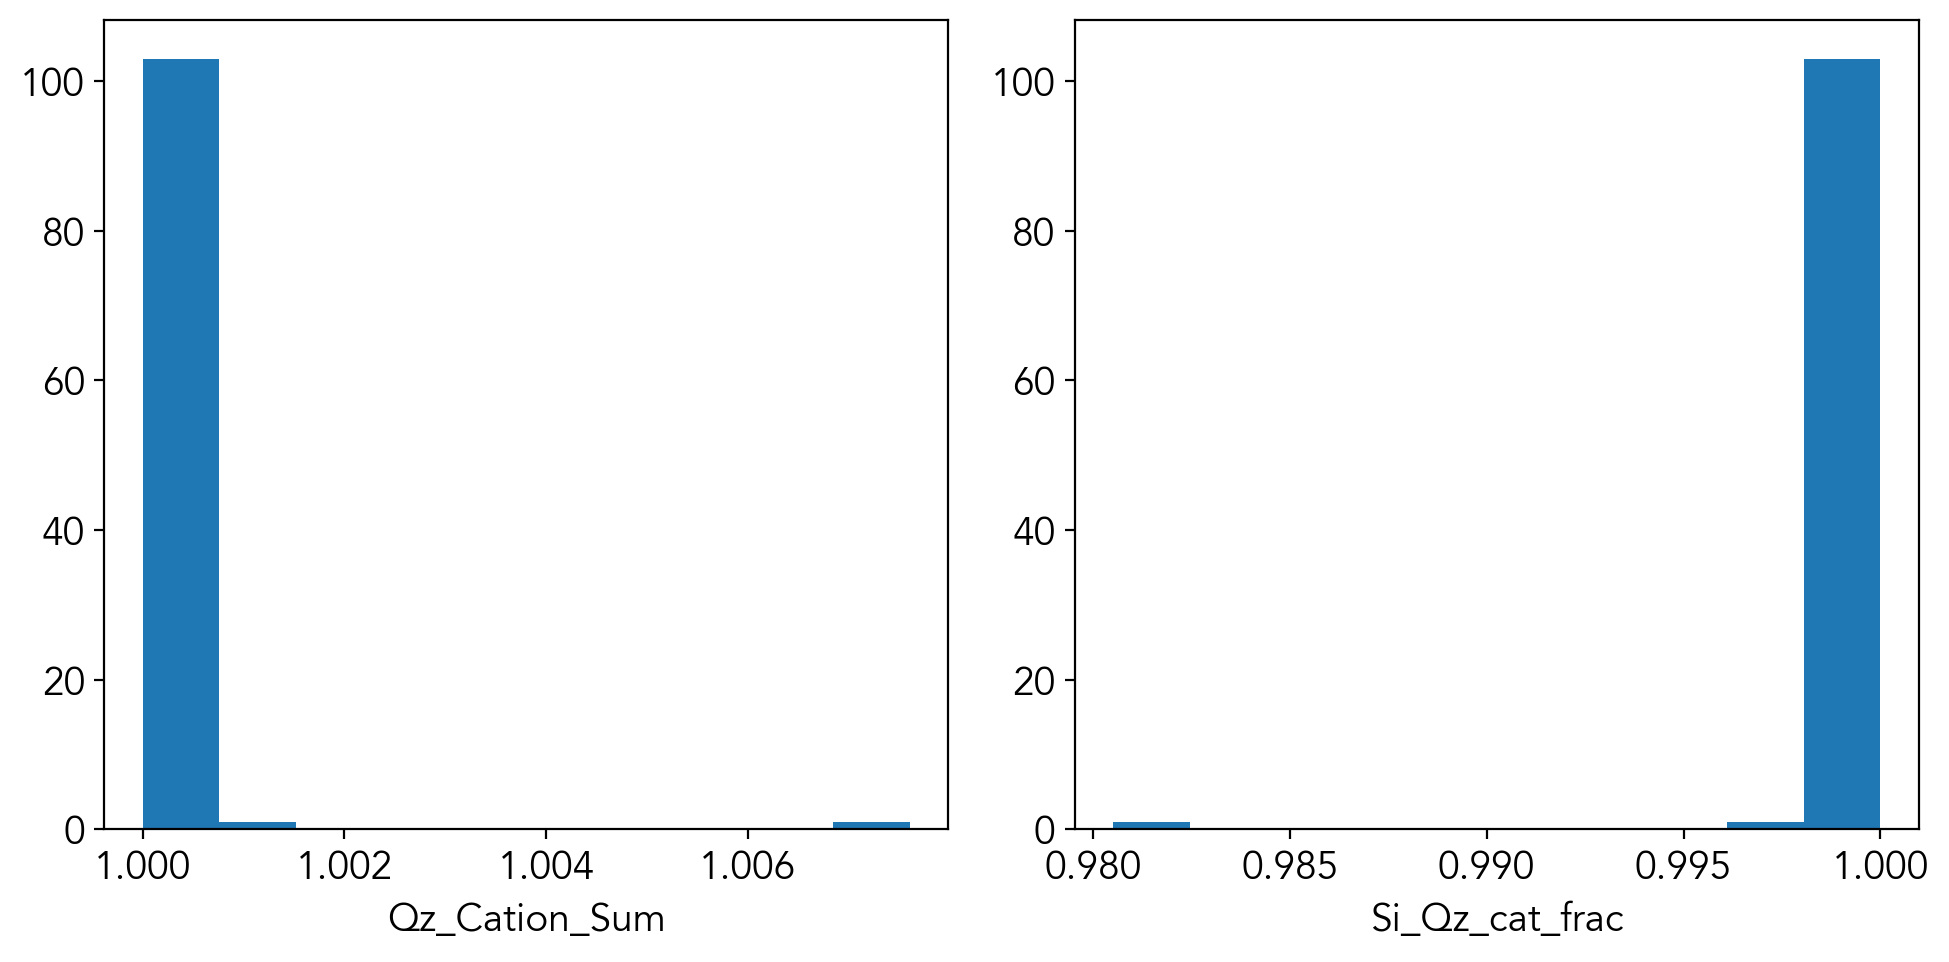

In [11]:
LEPR_Qz_PreFilt = pt.import_excel('MachineLearning_MinClass.xlsx', sheet_name="Quartz")['my_oxides']
LEPR_Qz_PreFilt = LEPR_Qz_PreFilt.add_suffix("_Qz")
LEPR_Qz_cs = mm.calculate_quartz_components(qz_comps=LEPR_Qz_PreFilt, append = '_Qz')
LEPR_Qz_Pre = LEPR_Qz_cs
LEPR_Qz = LEPR_Qz_PreFilt.loc[((LEPR_Qz_cs.Qz_Cation_Sum.between(0.95, 1.1)))]

LEPR_Qz_nosuf = mm.SiteCalculator(LEPR_Qz, '_Qz', 'Quartz')

fig, ax = plt.subplots(1, 2, figsize = (10, 5))
ax = ax.flatten()
ax[0].hist(LEPR_Qz_Pre['Qz_Cation_Sum'], bins = 10)
ax[0].set_xlabel('Qz_Cation_Sum')
ax[1].hist(LEPR_Qz_Pre['Si_Qz_cat_frac'], bins = 10)
ax[1].set_xlabel('Si_Qz_cat_frac')
plt.tight_layout()

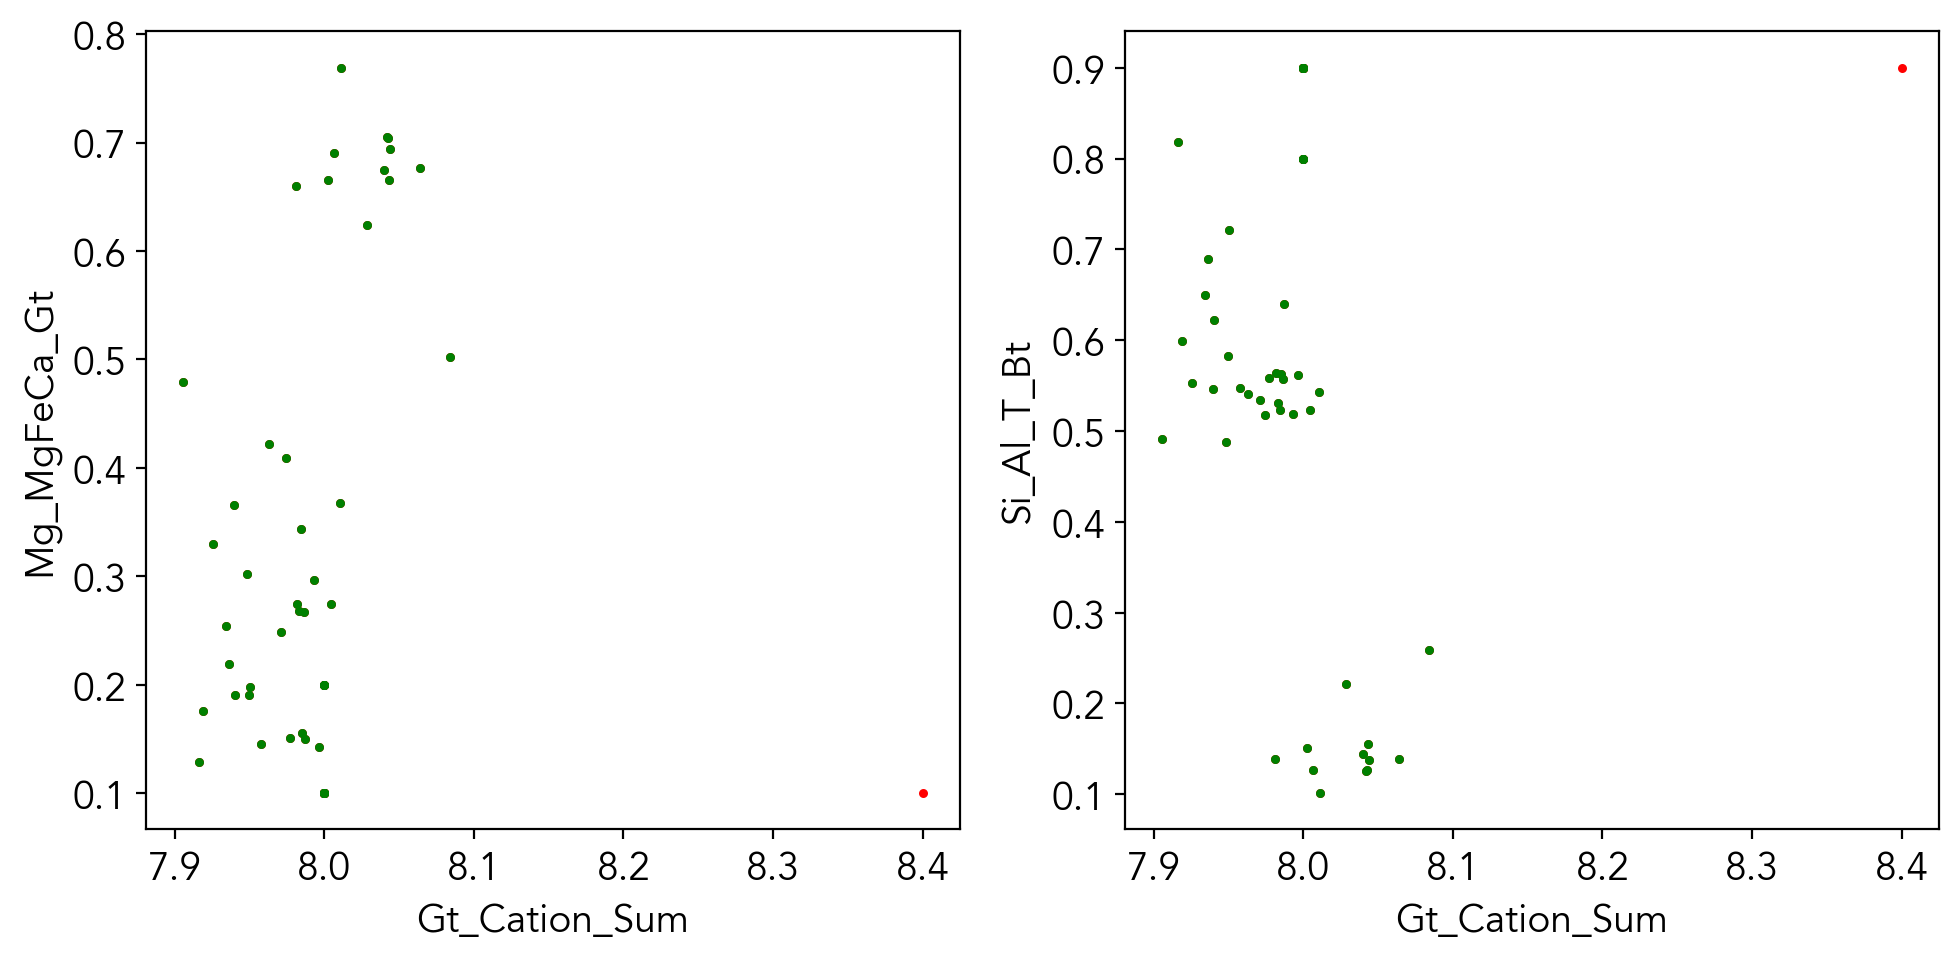

In [12]:
LEPR_Gt_PreFilt = pt.import_excel('MachineLearning_MinClass.xlsx', sheet_name="Garnet")['my_oxides']
LEPR_Gt_PreFilt = LEPR_Gt_PreFilt.add_suffix("_Gt")
LEPR_Gt_cs = mm.calculate_garnet_components(gt_comps=LEPR_Gt_PreFilt, append = '_Gt')
LEPR_Gt_Pre = pd.concat([LEPR_Gt_PreFilt, LEPR_Gt_cs], axis = 1)
LEPR_Gt = LEPR_Gt_PreFilt.loc[((LEPR_Gt_cs.Gt_Cation_Sum.between(7.9, 8.1)))]

LEPR_Gt_nosuf = mm.SiteCalculator(LEPR_Gt, '_Gt', 'Garnet')

fig, ax = plt.subplots(1, 2, figsize = (10, 5))
ax = ax.flatten()
ax[0].scatter(LEPR_Gt_Pre['Gt_Cation_Sum'], LEPR_Gt_Pre['Mg_MgFeCa_Gt'], s = 5, color = 'r')
ax[0].scatter(LEPR_Gt_nosuf['Gt_Cation_Sum'], LEPR_Gt_nosuf['Mg_MgFeCa_Gt'], s = 5, color = 'g')
ax[0].set_xlabel('Gt_Cation_Sum')
ax[0].set_ylabel('Mg_MgFeCa_Gt')
ax[1].scatter(LEPR_Gt_Pre['Gt_Cation_Sum'], LEPR_Gt_Pre['Fe_MgFeCa_Gt'], s = 5, color = 'r')
ax[1].scatter(LEPR_Gt_nosuf['Gt_Cation_Sum'], LEPR_Gt_nosuf['Fe_MgFeCa_Gt'], s = 5, color = 'g')
ax[1].set_xlabel('Gt_Cation_Sum')
ax[1].set_ylabel('Si_Al_T_Bt')
plt.tight_layout()

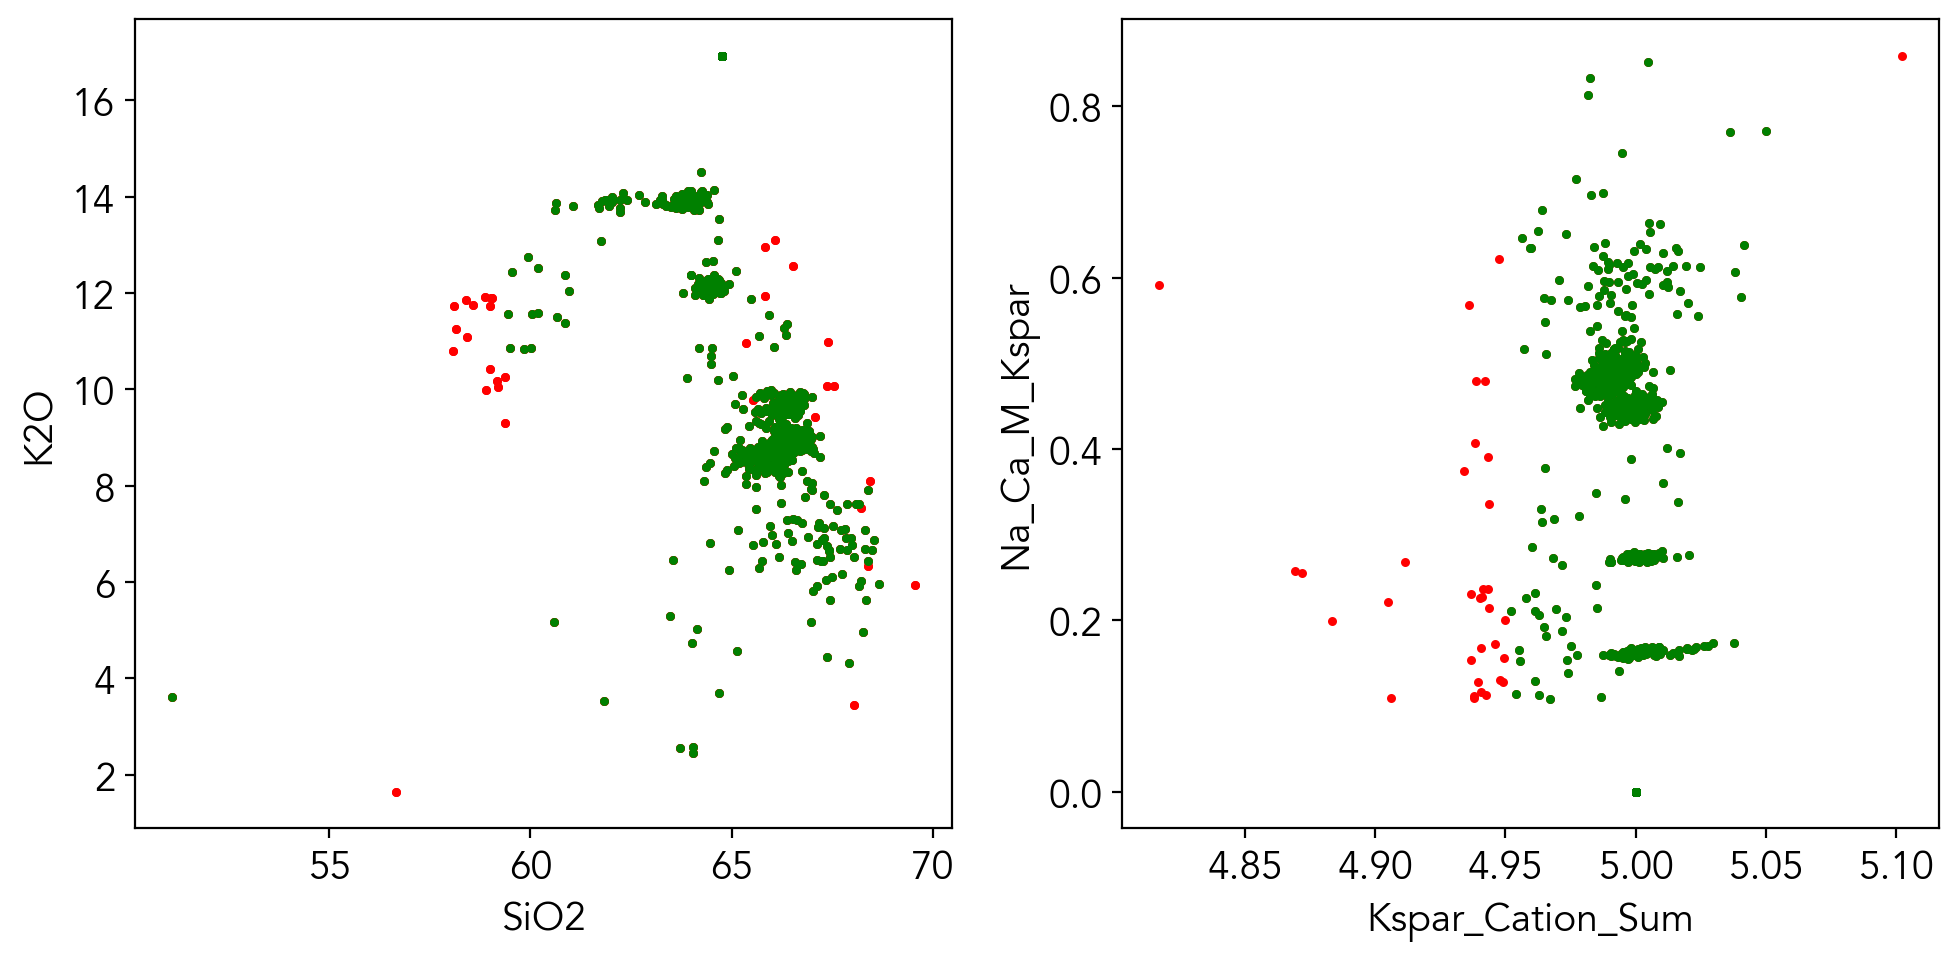

In [13]:
LEPR_Kspar_PreFilt = pt.import_excel('MachineLearning_MinClass.xlsx', sheet_name="Kspar")['Kspars']
LEPR_Kspar_cs = mm.calculate_kspar_components(kspar_comps=LEPR_Kspar_PreFilt, append = '_Kspar')
LEPR_Kspar_Pre = pd.concat([LEPR_Kspar_PreFilt, LEPR_Kspar_cs], axis = 1)
LEPR_Kspar = LEPR_Kspar_PreFilt.loc[((LEPR_Kspar_cs.Kspar_Cation_Sum.between(4.95, 5.05)) )]
LEPR_Kspar_nosuf = mm.SiteCalculator(LEPR_Kspar, '_Kspar', 'KSpar')

fig, ax = plt.subplots(1, 2, figsize = (10, 5))
ax = ax.flatten()
ax[0].scatter(LEPR_Kspar_Pre['SiO2_Kspar'], LEPR_Kspar_Pre['K2O_Kspar'], s = 5, color = 'r')
ax[0].scatter(LEPR_Kspar_nosuf['SiO2_Kspar'], LEPR_Kspar_nosuf['K2O_Kspar'], s = 5, color = 'g')
ax[0].set_xlabel('SiO2')
ax[0].set_ylabel('K2O')
ax[1].scatter(LEPR_Kspar_Pre['Kspar_Cation_Sum'], LEPR_Kspar_Pre['Na_Ca_M_Kspar'], s = 5, color = 'r')
ax[1].scatter(LEPR_Kspar_nosuf['Kspar_Cation_Sum'], LEPR_Kspar_nosuf['Na_Ca_M_Kspar'], s = 5, color = 'g')
ax[1].set_xlabel('Kspar_Cation_Sum')
ax[1].set_ylabel('Na_Ca_M_Kspar')
plt.tight_layout()

In [14]:
# LEPR_Amp_nosuf.loc[:, LEPR_Amp_nosuf.columns!='Amp_Cation_Sum']

def rename_columns(append): 
    oxides = ['SiO2', 'TiO2', 'Al2O3', 'FeOt', 'MnO', 'MgO', 'CaO', 'Na2O', 'K2O', 'Cr2O3']
    oxides_min = [oxide + append for oxide in oxides]
    
    dictionary = dict(zip(oxides_min, oxides))

    return dictionary

LEPR_Amp_nosuf = mm.SiteCalculator(LEPR_Amp, '_Amp', 'Amphibole')
LEPR_Amp_nosuf = LEPR_Amp_nosuf.rename(columns=rename_columns('_Amp'))
LEPR_Amp_nosuf = LEPR_Amp_nosuf.drop(columns=['F_Amp', 'Cl_Amp'], errors='ignore')

LEPR_Cpx_nosuf = mm.SiteCalculator(LEPR_Cpx, '_Cpx', 'Clinopyroxene')
LEPR_Cpx_nosuf = LEPR_Cpx_nosuf.rename(columns=rename_columns('_Cpx'))
LEPR_Cpx_nosuf = LEPR_Cpx_nosuf.drop(columns=['Sample_ID_Cpx'], errors='ignore')

LEPR_Opx_nosuf = mm.SiteCalculator(LEPR_Opx, '_Opx', 'Orthopyroxene')
LEPR_Opx_nosuf = LEPR_Opx_nosuf.rename(columns=rename_columns('_Opx'))
LEPR_Opx_nosuf = LEPR_Opx_nosuf.drop(columns=['Sample_ID_Opx'], errors='ignore')

LEPR_Plag_nosuf = mm.SiteCalculator(LEPR_Plag, '_Plag', 'Plagioclase')
LEPR_Plag_nosuf = LEPR_Plag_nosuf.rename(columns=rename_columns('_Plag'))
LEPR_Plag_nosuf = LEPR_Plag_nosuf.drop(columns=['Sample_ID_Plag'], errors='ignore')

LEPR_Ol_nosuf = mm.SiteCalculator(LEPR_Ol, '_Ol', 'Olivine')
LEPR_Ol_nosuf = LEPR_Ol_nosuf.rename(columns=rename_columns('_Ol'))
LEPR_Ol_nosuf = LEPR_Ol_nosuf.drop(columns=['NiO_Ol'], errors='ignore')
LEPR_Ol_nosuf = LEPR_Ol_nosuf.drop(columns=['Sample_ID_Ol'], errors='ignore')

LEPR_Sp_nosuf = mm.SiteCalculator(LEPR_Sp, '_Sp', 'Spinel')
LEPR_Sp_nosuf = LEPR_Sp_nosuf.rename(columns=rename_columns('_Sp'))
LEPR_Sp_nosuf = LEPR_Sp_nosuf.drop(columns=['NiO_Sp'], errors='ignore')
LEPR_Sp_nosuf = LEPR_Sp_nosuf.drop(columns=['Sample_ID_Sp'], errors='ignore')

LEPR_Ox_nosuf = mm.SiteCalculator(LEPR_Ox, '_Sp', 'Oxide')
LEPR_Ox_nosuf = LEPR_Ox_nosuf.rename(columns=rename_columns('_Sp'))
LEPR_Ox_nosuf = LEPR_Ox_nosuf.drop(columns=['NiO_Sp', 'Sample_ID_Sp'], errors='ignore')

LEPR_Ap_nosuf = mm.SiteCalculator(LEPR_Ap_PreFilt, '_Ap', 'Apatite')
LEPR_Ap_nosuf = LEPR_Ap_nosuf.rename(columns=rename_columns('_Ap'))
LEPR_Ap_nosuf = LEPR_Ap_nosuf.drop(columns=['P2O5_Ap'], errors='ignore')

LEPR_Bt_nosuf = mm.SiteCalculator(LEPR_Bt, '_Bt', 'Biotite')
LEPR_Bt_nosuf = LEPR_Bt_nosuf.rename(columns=rename_columns('_Bt'))
LEPR_Bt_nosuf = LEPR_Bt_nosuf.drop(columns=['P2O5_Bt'], errors='ignore')

LEPR_Qz_nosuf = mm.SiteCalculator(LEPR_Qz, '_Qz', 'Quartz')
LEPR_Qz_nosuf = LEPR_Qz_nosuf.rename(columns=rename_columns('_Qz'))
LEPR_Qz_nosuf = LEPR_Qz_nosuf.drop(columns=['P2O5_Qz'], errors='ignore')

LEPR_Gt_nosuf = mm.SiteCalculator(LEPR_Gt, '_Gt', 'Garnet')
LEPR_Gt_nosuf = LEPR_Gt_nosuf.rename(columns=rename_columns('_Gt'))
LEPR_Gt_nosuf = LEPR_Gt_nosuf.drop(columns=['P2O5_Gt'], errors='ignore')

LEPR_Kspar_nosuf = mm.SiteCalculator(LEPR_Kspar, '_Kspar', 'KSpar')
LEPR_Kspar_nosuf = LEPR_Kspar_nosuf.rename(columns=rename_columns('_Kspar'))
LEPR_Kspar_nosuf = LEPR_Kspar_nosuf.drop(columns=['Sample_ID_Kspar'], errors='ignore')

LEPR_AllPhases = pd.concat([LEPR_Amp_nosuf, LEPR_Cpx_nosuf, LEPR_Opx_nosuf, LEPR_Plag_nosuf, LEPR_Ol_nosuf, 
    LEPR_Sp_nosuf, LEPR_Ox_nosuf, LEPR_Ap_nosuf, LEPR_Bt_nosuf, LEPR_Qz_nosuf, LEPR_Gt_nosuf, LEPR_Kspar_nosuf], 
    axis = 0, ignore_index = True)

In [15]:
LEPR_AllPhases.to_csv('./LEPR/LEPR_AllPhases.csv')
LEPR_AllPhases

,SiO2,TiO2,Al2O3,FeOt,MnO,MgO,CaO,Na2O,K2O,Cr2O3,...,Qz_Cation_Sum,Mg_MgFeCa_Gt,Fe_MgFeCa_Gt,Ca_MgFeCa_Gt,,Al_Fe_Mn_Cr_Y_Gt,Gt_Cation_Sum,Na_Ca_M_Kspar,Si_Al_T_Kspar,Kspar_Cation_Sum
0,41.0000,1.510000,15.1000,13.8,0.36,11.60,10.800000,2.13000,0.7800,0.0,...,1.371468,0.427984,0.285625,0.286390,2.245662,2.282439,8.228805,0.814383,3.049578,5.485870
1,40.7000,1.650000,15.0000,16.5,0.25,10.10,10.500000,2.08000,0.7000,0.0,...,1.369136,0.375425,0.344060,0.280515,2.060821,2.465858,8.214818,0.798159,3.048822,5.476545
2,40.0000,1.850000,16.0000,15.5,0.37,9.48,10.600000,1.90000,0.8200,0.0,...,1.363260,0.367531,0.337105,0.295363,2.009675,2.508732,8.179561,0.790590,3.093620,5.453041
3,42.5000,2.920000,12.5000,12.5,0.40,13.20,10.500000,2.24000,0.5100,0.0,...,1.363342,0.475523,0.252613,0.271864,2.383477,1.940930,8.180053,0.801127,2.940381,5.453369
4,42.1000,1.910000,13.9000,17.3,0.39,10.40,10.100000,1.84000,0.5800,0.0,...,1.360014,0.380060,0.354660,0.265280,2.039067,2.389504,8.160082,0.743016,3.019850,5.440054
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5998,61.6998,0.091662,18.3270,0.0,0.00,0.00,0.003693,1.77829,13.7610,0.0,...,1.254193,0.000000,0.000000,1.000000,0.000285,1.557272,7.525158,0.165910,4.003755,5.016772
5999,63.7160,0.000000,18.6734,0.0,0.00,0.00,0.005477,1.75034,13.7923,0.0,...,1.248579,0.000000,0.000000,1.000000,0.000412,1.544923,7.491476,0.159095,4.011786,4.994318
6000,63.2802,0.000000,18.7136,0.0,0.00,0.00,0.000000,1.76903,14.0035,0.0,...,1.252331,NaN,NaN,NaN,0.000000,1.554191,7.513983,0.161132,4.008935,5.009322
6001,63.7372,0.031927,18.6757,0.0,0.00,0.00,0.000000,1.73697,13.8576,0.0,...,1.248886,NaN,NaN,NaN,0.000000,1.544053,7.493314,0.157499,4.010151,4.995542


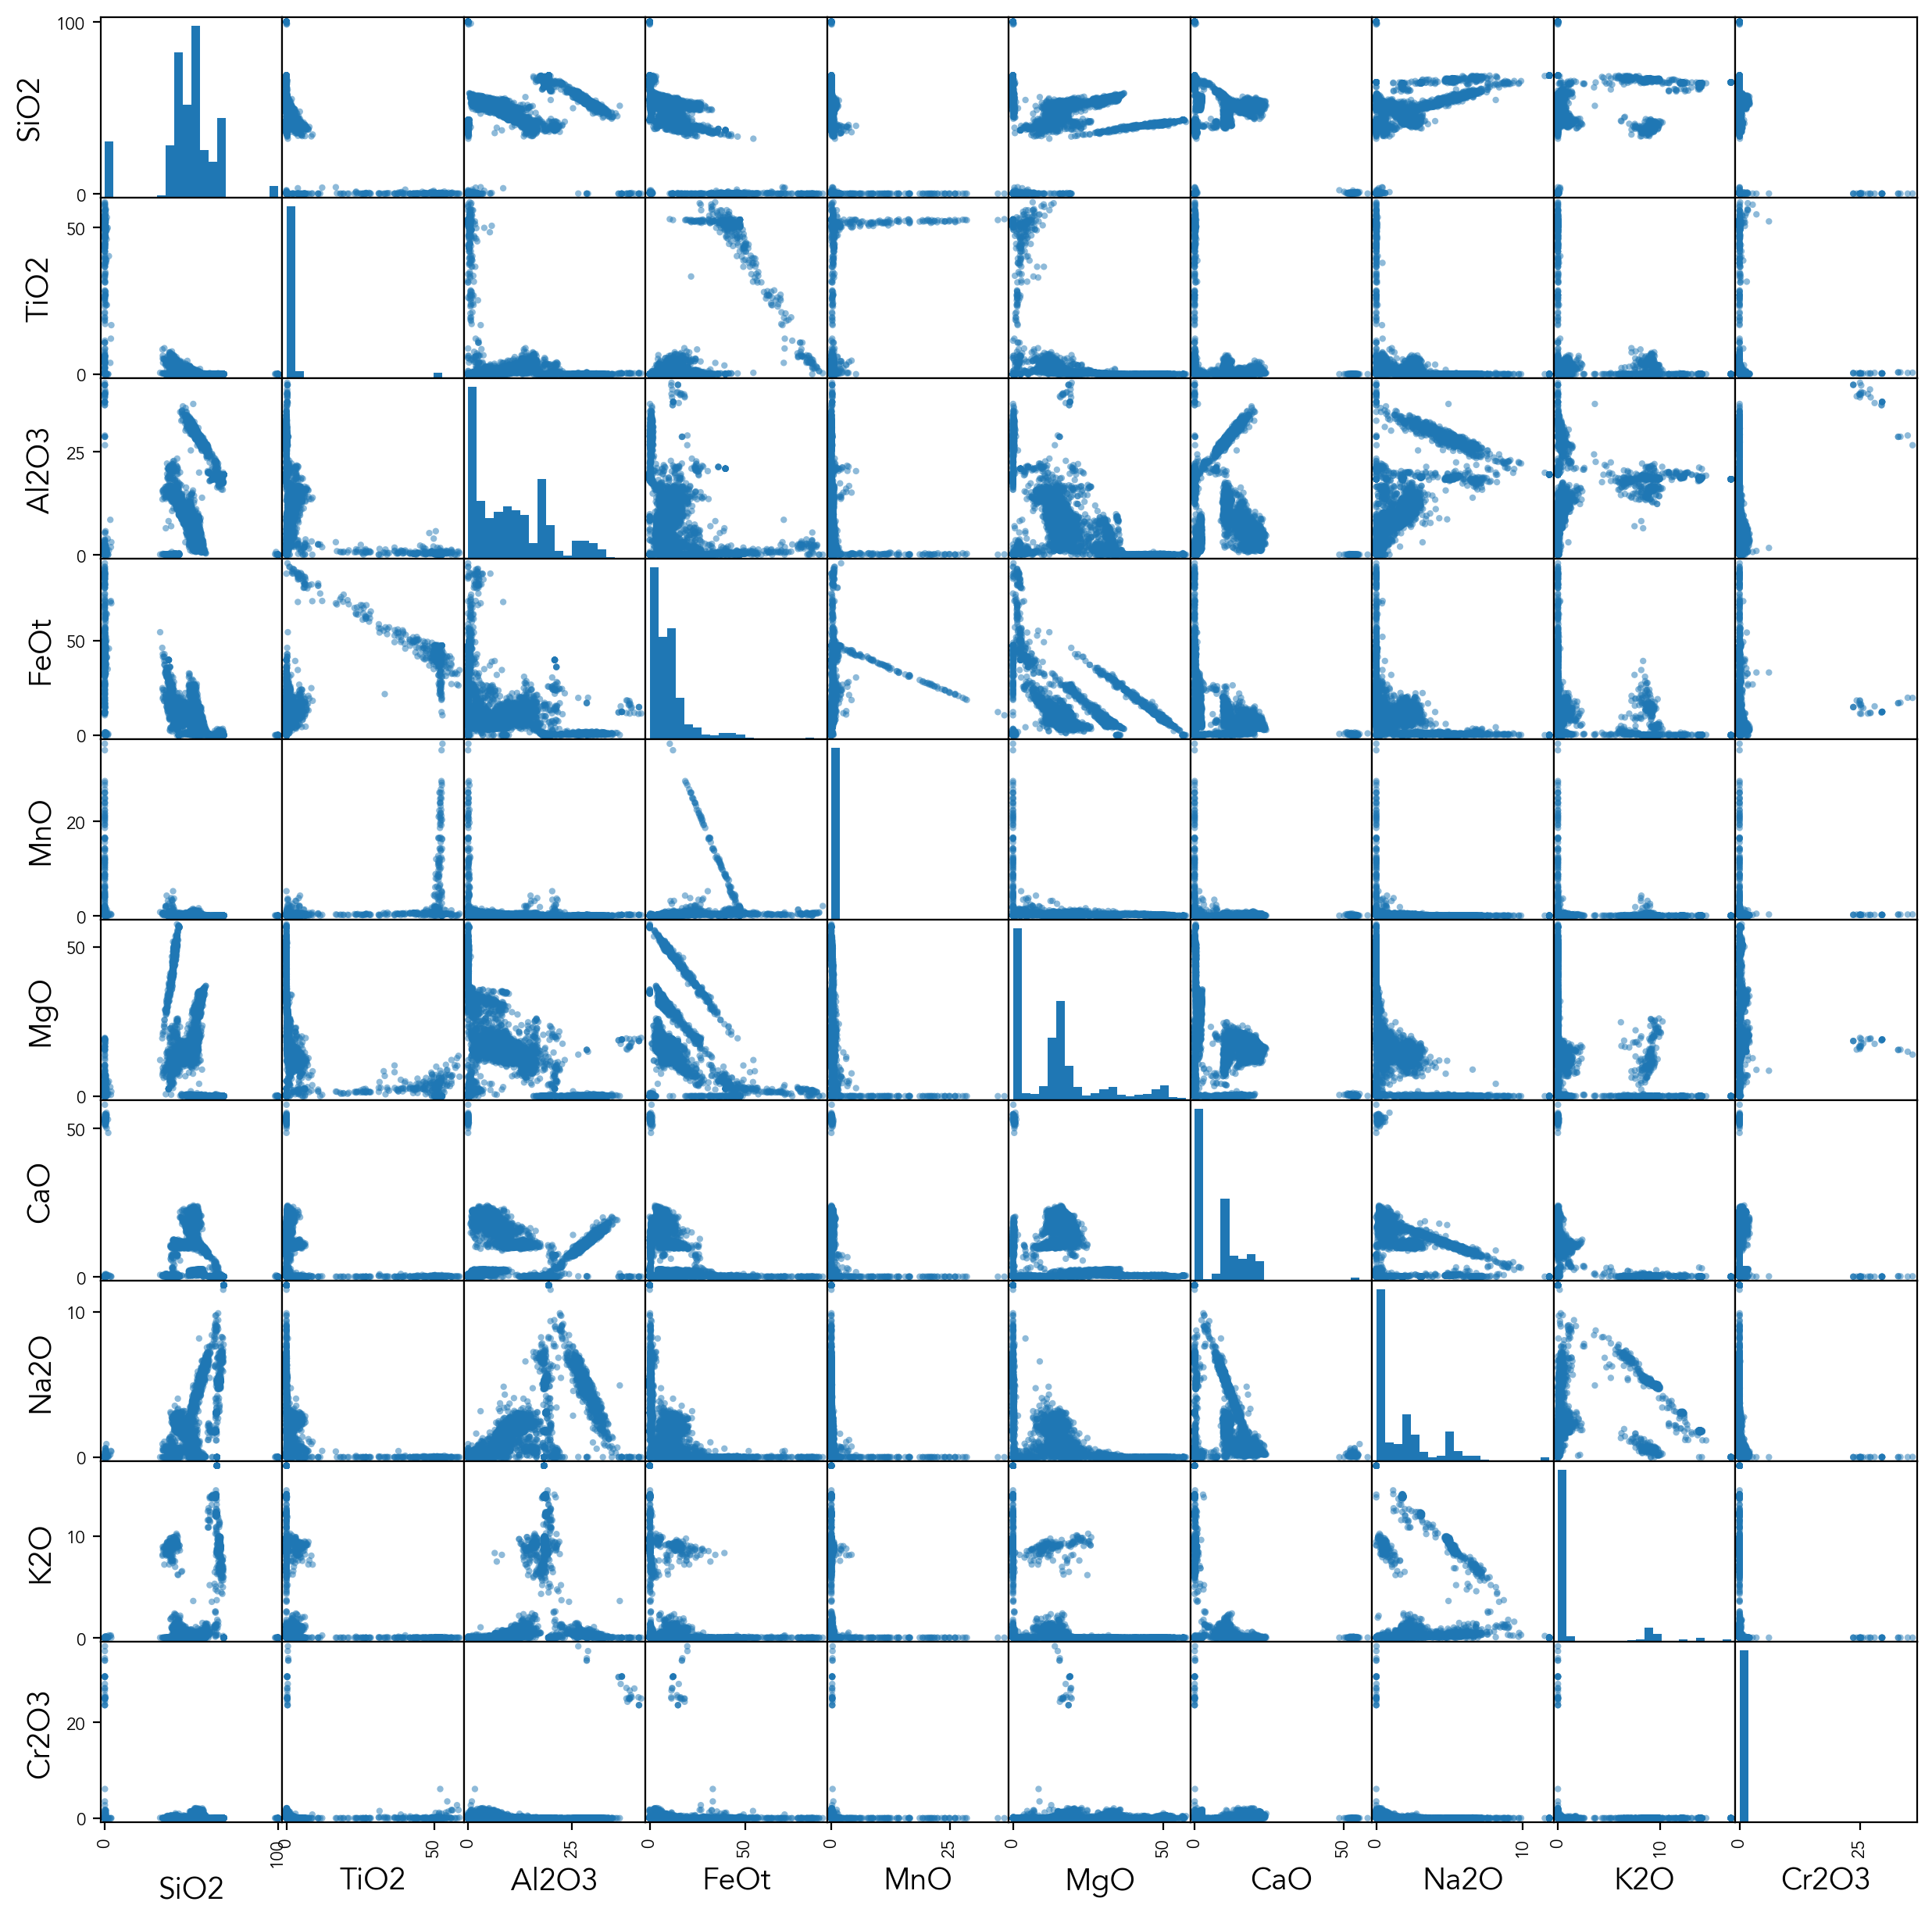

In [16]:
oxides = ['SiO2', 'TiO2', 'Al2O3', 'FeOt', 'MnO', 'MgO', 'CaO', 'Na2O', 'K2O', 'Cr2O3']
pd.plotting.scatter_matrix(LEPR_AllPhases[oxides], figsize = (15, 15), hist_kwds={'bins':20})
plt.show()